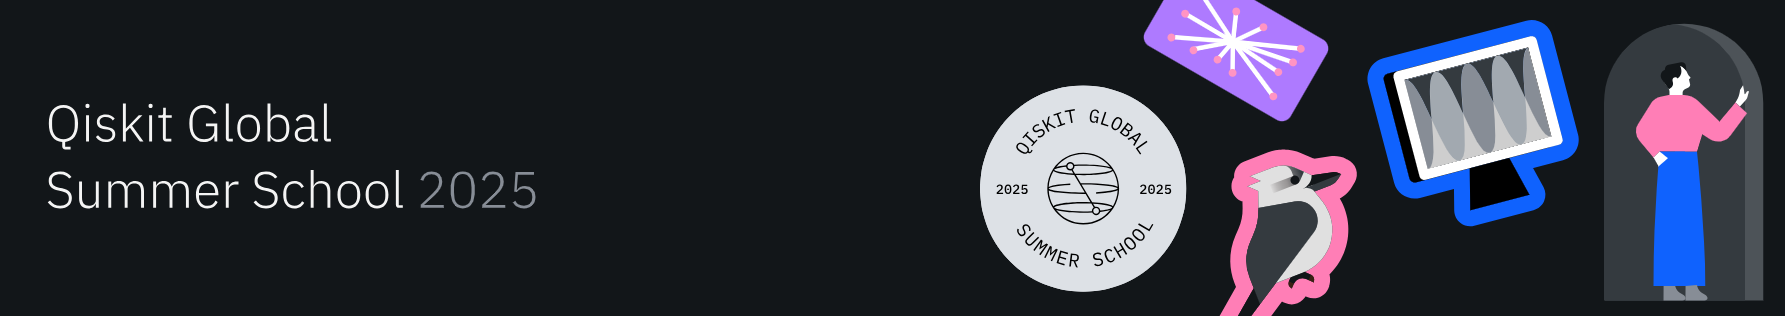



# Lab 3: The Power of 'good sampling' for simulating a chemistry Hamiltonian with SQD

Welcome to the third coding challenge of the Qiskit Global Summer School. In this lab, we explore one of the most promising applications of quantum computing, which is quantum chemistry. We present you with a real-life example of simulating a molecule using a quantum computer based on a workflow that quantum chemists may usually follow. We will explain what each step takes to achieve this and walk you through the entire workflow.

**Recommended study**<br>
Prior to going through this challenge, we recommend that you take a moment and check out the [Variational Algorithm Design](https://quantum.cloud.ibm.com/learning/en/courses/variational-algorithm-design) course and one of our latest courses on IBM Quantum Learning, [Quantum Diagonalization Algorithms](https://quantum.cloud.ibm.com/learning/en/courses/quantum-diagonalization-algorithms/skqd). 


# Table of Contents

* [Part 1: Introduction](#part-1-introduction)
    * 1.1 Objective
    * 1.2 What Are Atoms?
    * 1.3 The Schrödinger Equation
    * 1.4 Basis Set Approximation - Smart Building
    * 1.5 The Hamiltonian
    * [Exercise 1](#exercise1): Measure the size of the $O_2$ Hamiltonian
* [Part 2: Variational Quantum Eigensolver](#part-2-variational-quantum-eigensolver)
    * VQE – A Team-Up Between Classical and Quantum Computers
* [Part 3: What is Sample-based Quantum Diagonalization (SQD)?](#part-3-what-is-sample-based-quantum-diagonalization-(SQD)?)
    * SQD Approach: Reconstruct the Hamiltonian with 'good samples'
    * Choosing relevant configurations
    * Dealing with the effects of noise with configuration recovery
* [Part 4: How to simulate a $N_2$ molecule with SQD](#part-4-how-to-simulate-a-$N_2$-molecule-with-SQD)
    * [Exercise 2](#exercise2): Flip a bit by configuration recovery
* [Part 5: Improve the ansatz](#part-5-improve-the-ansatz)
    * [Exercise 3](#exercise3): Change the basis set
    * [Exercise 4](#exercise4): Select the best layout
    * [Exercise 5](#exercise5): Add more interaction to LUCJ ansatz
* [Bonus: Real hardware execution with error mitigation ](Bonus-real-hardware-execution-with-error-mitigation )


## Requirements

Before starting this tutorial, please make sure that you have the following installed:

* Qiskit SDK 2.0 or later with visualization support (`pip install 'qiskit[visualization]'`)
* Qiskit Runtime 0.40 or later (`pip install qiskit-ibm-runtime`)
* Qiskit Addons SQD 0.11.0 or later (`pip install qiskit-addon-sqd`)
* ffsim (`pip install ffsim`)


<div class="alert alert-block alert-warning">
    
⚠️ **Note:** You need to have the below packages installed in order to run this lab, of which some are not available on Windows. If you are using Windows we recommend you to use [an online lab environment.](https://quantum.cloud.ibm.com/docs/en/guides/online-lab-environments#online-lab-environments)
</div>

In [6]:
%pip install "qc-grader[qiskit,jupyter] @ git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git"
%pip install pyscf
%pip install ffsim
%pip install qiskit_addon_sqd
%pip install 'qiskit[visualization]'
%pip install qiskit_ibm_runtime

  Cloning https://github.com/qiskit-community/Quantum-Challenge-Grader.git to /tmp/pip-install-dhtirej9/qc-grader_a5b74330ecd8483b9dc193df654cfe0f
  Running command git clone --filter=blob:none --quiet https://github.com/qiskit-community/Quantum-Challenge-Grader.git /tmp/pip-install-dhtirej9/qc-grader_a5b74330ecd8483b9dc193df654cfe0f
  Resolved https://github.com/qiskit-community/Quantum-Challenge-Grader.git to commit 1d7a6915623b0cfeac4c114391c279e9d98eb7f9
  Installing build dependencies ...   Resolved https://github.com/qiskit-community/Quantum-Challenge-Grader.git to commit 1d7a6915623b0cfeac4c114391c279e9d98eb7f9
  Installing build dependencies ... -done
  Getting requirements to build wheel ... one
  Getting requirements to build wheel ... -done
  Preparing metadata (pyproject.toml) ... one
  Preparing metadata (pyproject.toml) ... -done
done
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: 

In [7]:
import qiskit
import qc_grader
print(f"Qiskit version: {qiskit.__version__}")
print(f"Grader version: {qc_grader.__version__}")

Qiskit version: 2.1.1
Grader version: 0.22.12


You should have Qiskit version `>=2.0.0` and Grader `>=0.22.12`. If you see a lower version, you need to reinstall the grader and restart the kernel.
Also make sure you have set up everything according to lab 0 and test it with the cell below.

In [8]:
# Check that the account has been saved properly
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(name="qgss-2025")
service.saved_accounts()

{'default-ibm-cloud': {'channel': 'ibm_cloud',
  'url': 'https://cloud.ibm.com',
  'token': 'rqHNn40lAGhFvAvcgbkJ3xO0R37fxY1NmxNcC2lvZbtt',
  'instance': 'crn:v1:bluemix:public:quantum-computing:us-east:a/9418f3a1469ab60e6a7b8c679c5dcf0b:2842dc64-4cb1-4fff-8b1f-326d1dd2e1ca::',
  'verify': True,
  'private_endpoint': False},
 'qgss-2025': {'channel': 'ibm_quantum_platform',
  'url': 'https://cloud.ibm.com',
  'token': 'rqHNn40lAGhFvAvcgbkJ3xO0R37fxY1NmxNcC2lvZbtt',
  'instance': 'crn:v1:bluemix:public:quantum-computing:us-east:a/9418f3a1469ab60e6a7b8c679c5dcf0b:2842dc64-4cb1-4fff-8b1f-326d1dd2e1ca::',
  'verify': True,
  'private_endpoint': False}}

# Imports

In [9]:
# Import common packages first
import numpy as np
from math import comb
import warnings
import pyscf
import matplotlib.pyplot as plt
import pickle
from functools import partial

# Import qiskit classes
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_gate_map
from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch

# Import qiskit ecosystems
import ffsim
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit_ibm_runtime import SamplerOptions

# Import grader
from qc_grader.challenges.qgss_2025 import (
    grade_lab3_ex1, 
    grade_lab3_ex2, 
    grade_lab3_ex3,
    grade_lab3_ex4,
    grade_lab3_ex5
)

# 1. Introduction 

## 1.1 Objective

The objective of this Lab is to learn the basics and general workflow of quantum chemistry calculations. You will also learn about a useful hybrid quantum-classical algorithm called Sample-based Quantum Diagonalization (SQD) algorithm. SQD is a classical post-processing technique which acts on samples obtained from a quantum circuit after execution on a QPU. It is useful for finding eigenvalues and eigenvectors of quantum operators, such as the Hamiltonian of a quantum system, and uses quantum and distributed classical computing together. 


## 1.2 What Are Atoms?
Everything around you is made of atoms—the tiny building blocks of matter. The word “atom” comes from a Greek word that means “can’t be split.” A long time ago, a man named Democritus thought that all things were made of tiny, unbreakable pieces called atoms.

In 1913, Niels Bohr said electrons move in circles (orbits) around the center of the atom, like planets around the sun. 
But in 1926, Erwin Schrödinger said electrons don’t really move in perfect paths. Instead, they buzz around in "clouds" where they’re most likely to be found.

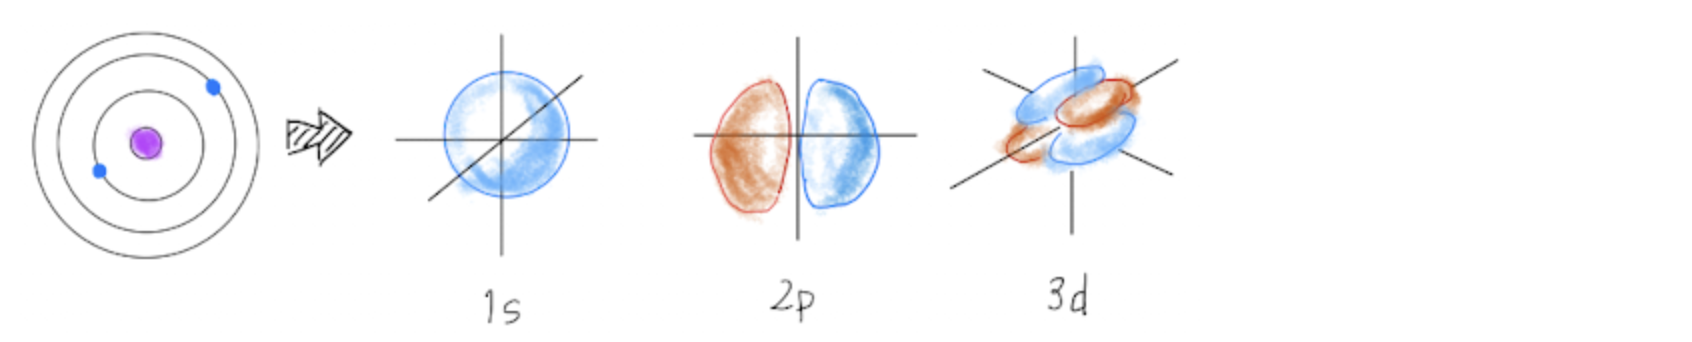

Fig 1. A sketch of Bohr’s atomic model (left) and Schrödinger’s atomic model based on quantum mechanical and wave nature of electrons (right).　 <br>


These clouds (called orbitals) have different shapes and energy levels. Electrons usually stay in the lowest energy level (the ground state), but they can jump to higher ones if they get energy. When they fall back down, they give off energy.

## 1.3 The Schrödinger Equation

Erwin Schrödinger's contributions to quantum mechanics go beyond introducing a new electronic model; he established the famous Schrödinger equation. The time-independent Schrödinger equation is:
$$
\hat{H}|\psi\rangle = {E}|\psi\rangle
$$

**$\hat{H}$**  : Hamiltonian operator <br>
**$|\psi\rangle$** : Wave function (state of the system) <br>
**${E}$** : Measured energy (eigenvalue) <br>

**The goal of quantum chemistry is to solve the Schrödinger Equation** for the wave function. The wave function that satisfies the Schrödinger Equation can help us find out interesting properties of that quantum system such as energy, momentum, spin, magnetization, and more. 

In quantum chemistry, we are often interested in finding **the ground state energy**. This is because once we know the ground state energy of a molecule, we can learn a lot such as:

- the shape a molecule will most likely take in a stable form. (often called the "equilibrium" state)
- how molecules might change or react during chemical reactions.
- how a drug might stick to a protein in the body seen in Docking simulations.
  
In short, finding the ground state is like finding the starting point for all the interesting things molecules can do.

But for big molecules, **solving the Schrödinger Equation exactly is extremely difficult** because the wave function, which describes the spatial distribution of electrons, is highly complex. So, instead of solving it perfectly, scientists make good guesses or approximations that are close enough.

## 1.4 Basis Set Approximation - Smart Building
One of the key approximations in quantum chemistry is the use  of a **basis set** approach. A basis set is **a collection of mathematical functions used to approximate the orbitals (wavefunctions) of electrons** in atoms and molecules. Since we can't solve the Schrödinger equation exactly for most systems, we use basis sets to make the problem computationally tractable. Instead of working with full, continuous atomic orbitals, we approximate them using a set of predefined mathematical functions—usually Gaussian-type or Slater-type orbitals.

This method is known as the Linear Combination of Atomic Orbitals (LCAO). The idea is simple: we build molecular orbitals by combining basis functions. It’s like building a complex shape using a sum of simpler, known shapes.
- A small basis set (fewer functions) gives a rough but fast approximation.
- A larger basis set improves accuracy but requires much more computational power.

<div class="alert alert-block alert-info"> 
<b>Types of Basis Functions</b><br>

- **Slater-type orbitals (STOs)**: These are mathematical functions that look very similar to real atomic orbitals (the shapes electrons naturally form around atoms). They describe how electron density drops off with distance from the nucleus.
- **Gaussian-type orbitals (GTOs)**: Easier to work with computationally, even though they don't resemble orbitals as closely. Often used in practice.</div>


The Slater-type orbital (STO) can be approximated by a combination of Gaussian-type orbitals (GTOs). In other words, we combine multiple Gaussians with different widths to mimic the shape of an STO. This combination is called a **contracted Gaussian function**. This idea is the basis for different kinds of basis sets, like minimal (simple) and split-valence (more accurate) sets.

- **Minimal Basis Set**:
A basis set that uses just one function per orbital (e.g., one function for $1s$, one for $2s$, etc.).
In STO-3G, for example, each STO is approximated using 3 Gaussians.
- **Split-Valence Basis Set**:
These are more flexible and provide more accurate representations than minimal basis sets.
They split the valence orbitals (the outermost orbital that contain electrons involved in bonding with other atoms) into two or more parts, each approximated with different combinations of Gaussians (like 6-31G).
This allows for better accuracy in chemical bonding and reactions.

### Common Basis Sets

|   Basis	Set    | Description	| Example Use | Computational Cost |
| ----------------- | ----------- | ----------- | ----------- |
| **STO-3G**	| Uses 3 Gaussians (the "3G") to mimic 1 STO. (aka 'Minimal basis')| Fast, rough estimate for small molecules| Low |
| **6-31G**	  | Uses 6 Gaussians to mimic 1 STO (the "6") for each core orbital. For each valence  (outer) orbital, a contracted function made of 3 Gaussians (the "3") and a single uncontracted Gaussian (the "1") are used.	| Good balance between speed and accuracy| Medium |
| **cc-pVDZ**	| Designed to improve electron correlation calculations. Adds polarization functions. Uses 2 basis functions for each valence orbitals instead of 1.	| More accurate than STO-3G and 6-31G when simulating systems that have stronger correlations, but more computationally expensive.| High |

> NOTE: The computational cost referred to in the table above is the classical cost of computing the molecular integrals. The more functions in your basis set, the more accurate your results—but computations take longer.

To summarize, instead of solving the full Schrödinger equation exactly (which is almost always impossible for molecules), we build a flexible, approximate wave function using known functions—and then tune it to minimize the system’s energy.

## 1.5 The Hamiltonian

At the heart of the Schrödinger equation, and to that extent in every quantum chemistry problem, there is a **Hamiltonian**. It’s a central object in both classical mechanics and quantum mechanics, and is essentially a function that represents the total energy (kinetic + potential) of a physical system.  

In quantum mechanics, the Hamiltonian $\hat{H}$ becomes an operator acting on the wave function $|\psi\rangle$. In a chosen basis, these wave functions $|\psi\rangle$ can be described as vectors and Hamiltonians in matrix form. 

In most quantum chemistry problems, the first and most important goal was to calculate its ground state energy. This calculation can be done by diagonalizing a Hamiltonian (matrix) and computing its eigenvalues and eigenvectors.

The size or dimensions of a molecular Hamiltonian can be determined by finding the number of combinations the electrons can occupy the spatial orbitals. This is essentially a combination problem that can quickly grow exponential in size making the diagonalization uncontractable for most interesting molecules. 

### Example: Calculate the size of the $N_2$ Hamiltonian
We would like you to get a sense of how large a Hamiltonian matrix $H$ can grow, even for a relatively small molecule like nitrogen ($N_2$), depending on how accurately you want to simulate it. In the following example, we chose the number of spatial orbitals, spin orbitals, and electrons of $N_2$ to use in our calculations. 

Using the number of spatial orbitals and electrons in the table below, let's compute the number of ways the electrons can occupy the spatial orbitals (spin configurations), which indicates the size of the $N_2$ molecule Hamiltonian.


|   |    STO-3G  |  6-31G  | cc-pVDZ  |  
|:-------|:------:|:-------:|:-------:|
|Spatial orbitals | (10) **8**| (18) **16** | (28) **26** |
|Spin orbitals | (20) **16**| (36) **32**| (56) **52** |
| α-spin electrons  | (7) **5**| (7) **5**| (7) **5** |
| β-spin electrons  | (7) **5**| (7) **5**| (7) **5** |


<p style="text-align:center;">Table 1: Number of orbitals and electrons in specified basis sets for $N_2$</p>

- (#) : number of orbitals and electrons we specifically chose for the purpose of this example.
- **#** : number of orbitals or electrons when freezing the core orbital (*1s*) and reducing the number of electrons and spatial orbitals each by 2.

<div class="alert alert-block alert-warning">
    
⚠️ **Note:** In this example we treat the $1s$ (core) orbital as chemically inactive. This means we can freeze the core orbital and save 2 electrons and 2 spatial orbitals (i.e. 4 spin orbitals -> 4 qubits). This is another useful approximation technique you will frequently see in actual chemistry simulations. Applying this technique, please make sure to use the numbers in **bold** for calculating for all possible electron configurations for the $N_2$ Hamiltonian.
</div>

As you can tell, solving for all possible spin configurations is essentially a combination problem. Let's take a look at the math to calculate how many ways the **$\alpha$-spin (spin-up)** electrons and **$\beta$-spin (spin-down)** electrons can each occupy given spatial orbitals. For the total spin configurations we simply need to multiply them together. 

<p style="text-align:center;">Total electron configurations = (total α-spin configurations) × (total β-spin configurations)</p>

$$ \Large{n}\Large{C}n_α \times n\Large{C}n_β = \Large\frac{n!}{n_α!(n-n_α)!} \times \Large\frac{n!}{n_β!(n-n_β)!}  $$

Where
**$n$**: number of spatial orbitals,
**$n_α$**: number of α-spins,
**$n_β$**: number of β-spins

Now that we know how to obtain the total spin configurations, let's calculate this in each basis set and plot the results to see how the size of the Hamiltonian grows with more accuracy.

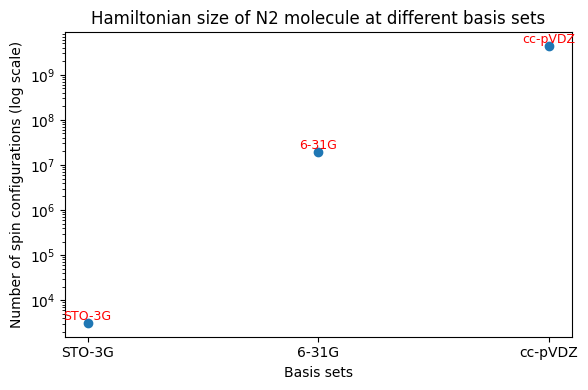

In [10]:
# Number of possible spin configurations
# Example: N2 molecule in STO-3G, 6-31G, and cc-pVDZ basis sets
# 14 electrons, 20 spin orbitals (from 10 spatial orbitals × 2)

# Calculate total electron configurations for each basis set
y1 = comb(8, 5) * comb(8, 5)       # STO-3G
y2 = comb(16, 5) * comb(16, 5)     # 6-31G
y3 = comb(26, 5) * comb(26, 5)     # cc-pVDZ

# Data
y = [y1, y2, y3]
x = list(range(len(y)))
labels = ['STO-3G', '6-31G', 'cc-pVDZ']

# Plot with logarithmic y-scale
plt.figure(figsize=(6, 4))
plt.plot(x, y, 'o')

plt.yscale('log')
plt.xticks(x, labels)
plt.xlabel('Basis sets')
plt.ylabel('Number of spin configurations (log scale)')
plt.title('Hamiltonian size of N2 molecule at different basis sets')

# Add labels above points
for i in range(len(x)):
    plt.text(x[i], y[i], f'{labels[i]}', fontsize=9, ha='center', va='bottom', color='red')

plt.tight_layout()
plt.show()

Note that the Y-axis above is in logarithmic scale. You can see how the number of spin configurations grows exponentially with a basis set choice of better approximation.

## Exercise 1: Measure the size of the $O_2$ Hamiltonian

Now let's calculate the size of oxygen $O_2$ in the `6-31G` basis. Oxygen has the same number of orbitals as $N_2$ but has 2 additional **$\alpha$-spin (spin-up)** electrons. The numbers you need to use in this exercise are provided in the table below. 

<a id="exercise_1"></a>
<div class="alert alert-block alert-success">
    
<b>Exercise 1: Measure the size of the $O_2$ Hamiltonian</b> 

Using the number of spatial orbitals and electrons in the table below, compute the total number of electron spin configurations for the oxygen $O_2$ molecule in the `6-31G` basis. **You may write your own code or calculate by hand to get the answer.**


|   |    STO-3G  |  6-31G  | cc-pVDZ  |  
|:-------|:------:|:-------:|:-------:|
|Spatial orbitals | (10) **8**| (18) **16** | (28) **26** |
|Spin orbitals | (20) **16**| (36) **32**| (56) **52** |
| α-spin electrons  | (9) **7**| (9) **7**| (9) **7** |
| β-spin electrons  | (7) **5**| (7) **5**| () **5** |


<p style="text-align:center;">Table 1: Number of orbitals and electrons in specified basis sets for $O_2$</p>

- (#) : number of orbitals or electrons based on actual atomic structure in the specified basis set.
- **#** : number of orbitals or electrons when freezing the core orbital (*1s*) and reducing the number of electrons and spatial orbitals each by 2.
</div>


<div class="alert alert-block alert-warning">
    
⚠️ **Note:** As we already saw in the previous example, we will treat the $1s$ (core) orbital as chemically inactive in this exercise. This means we can freeze the core orbital and save 2 electrons and 2 spatial orbitals (i.e. 4 spin orbitals -> 4 qubits). This is another useful approximation technique you will frequently see in actual chemistry simulations. Applying this technique, please make sure to use the numbers in **bold** for calculating for all possible electron configurations for the $O_2$ Hamiltonian.
</div>

In [11]:
# Exercise 1: Number of possible spin configurations
# Example: O2 molecule in 6-31G basis
# 16 electrons, 20 spin orbitals (from 10 spatial orbitals × 2)

# Calculate all valid electron configurations
# Hint: This is a combinatorial problem. You can calculate by hand and provide the answer or use the math.comb() method below.

# ---- TODO : Task 1 ---
### Provide your code below to calculate the total configurations

# Para O2 na base 6-31G (com core freezing):
# - 16 spatial orbitals (números em negrito da tabela)
# - 7 elétrons α-spin 
# - 5 elétrons β-spin
# 
# Número de configurações = C(n, k) onde n = spatial orbitals, k = número de elétrons de cada spin

α_config = comb(16, 7)  # C(16, 7) = configurações para elétrons α-spin
β_config = comb(16, 5)  # C(16, 5) = configurações para elétrons β-spin
total_config = (α_config)*(β_config)
# --- End of TODO ---

print(f"Total physical configurations for O2 in the given basis : {α_config:} x {β_config:} = {total_config}")

Total physical configurations for O2 in the given basis : 11440 x 4368 = 49969920


In [13]:
# total_config =  #provide your answer here if calculated by hand. Then uncomment this section before you submit your answer.
total_config =  49969920

In [14]:
# Submit your answer using following code

grade_lab3_ex1(total_config) # Expected result type: integer

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.
Congratulations 🎉! Your answer is correct and has been submitted.


After submitting your answer calculated in the 6-31G basis, try calculating the same in other basis sets (e.g. STO-3G, and cc-pVDZ) for comparison. Feel free to plot your results to see how the size grows.

# 2. Variational Quantum Eigensolver

So far, we've learned about the Schrödinger Equation, basis sets, and how the Hamiltonian of a physical system can grow exponentially in size depending on how accurately you want to simulate your system. Now let's talk about algorithms. 

One of the well-known algorithms among computational chemists who work with near-term quantum computers is perhaps the **Variational Quantum Eigensolver (VQE)**.

The Variational Quantum Eigensolver (VQE) is a hybrid quantum-classical algorithm used to optimize a cost function Hamiltonian based on the variational principle. Although this lab's main focus is on learning about a different kind of hybrid quantum-classical algorithm called Sample-based Quantum Diagonalization (SQD), it would be useful to briefly review the components of VQE as they form some of the important building blocks for SQD as well.

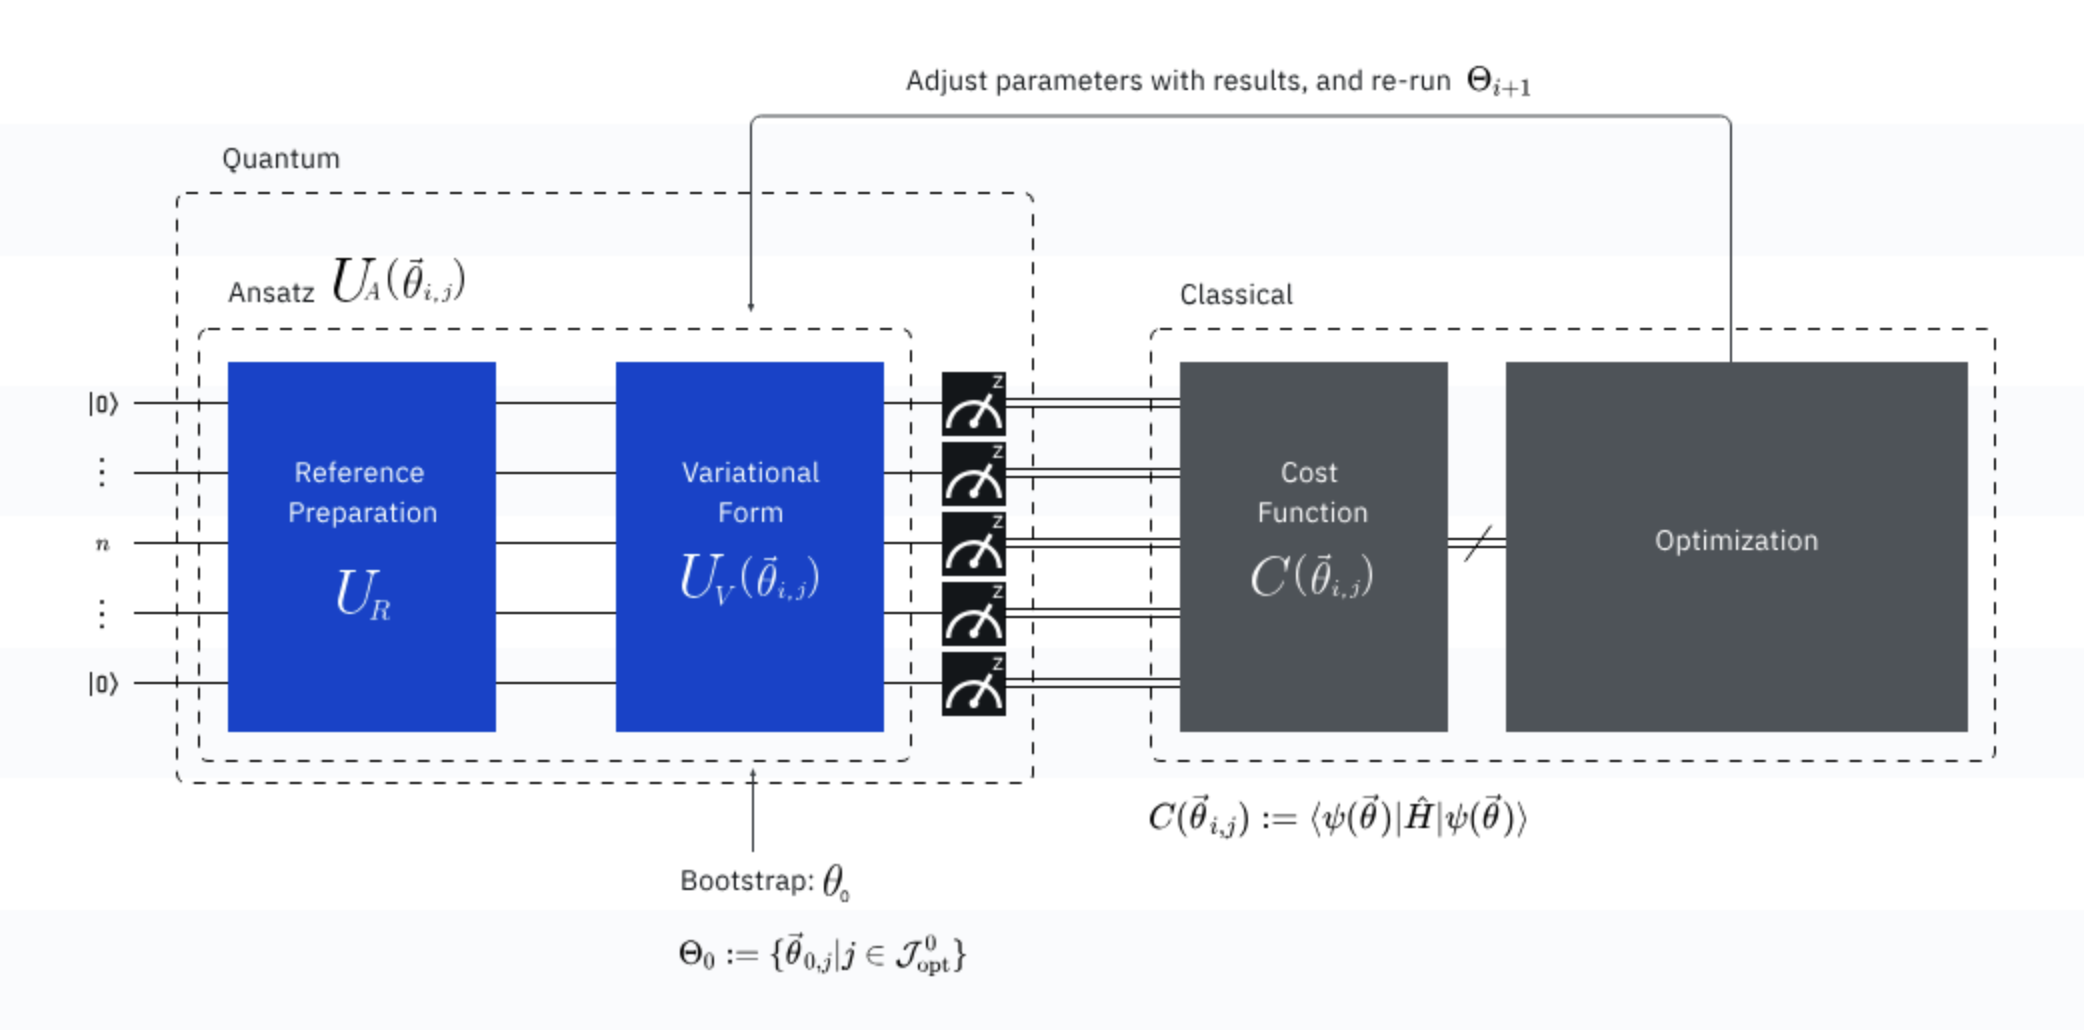

Fig 2. A diagram that shows the computational workflow of VQE

Summary of Computational Steps in VQE:

1. Prepare the quantum state $|\psi(𝜃)\rangle$(Quantum).
2. Measure expectation values $\langle\psi(𝜃)|\hat{H}|\psi(𝜃)\rangle$(Quantum). 
3. Compute the cost function $𝐸(𝜃)$(Classical).
4. Adjust the parameter $𝜃$ using classical optimization (Classical).
5. Repeat the steps until cost function $𝐸(𝜃)$ converges.

As you can tell from the above, the computational steps for executing VQE is an 'iterative' process - you need to repeat these steps many, many, times. This is a computationally costly procedure and becomes a limitation for an algorithm like VQE to scale and work with larger molecules. 

# 3. What is Sample-based Quantum Diagonalization (SQD)?

While VQE has been widely explored since its original proposal in 2014, it has certain limitations. As the Hamiltonian grows larger, obtaining the expectation value through the variational method becomes increasingly resource-intensive, and the algorithm does not scale well for larger molecules. This challenge motivates the study and implementation of Sample-based Quantum Diagonalization (SQD).

SQD was inspired by a hybrid quantum-classical method called quantum-selected configuration interaction (QSCI) introduced and published in [this paper](https://arxiv.org/abs/2302.11320). Similar to QSCI, SQD is also a hybrid quantum-classical algorithm in which a quantum computer is used to generate electronic configurations by sampling them from a quantum circuit, and then those configurations are used to form a subspace in which to project and diagonalize the electronic Hamiltonian.

This subspace will have dimensions that are smaller than the original Hamiltonian making it much easier to classically diagonalize.

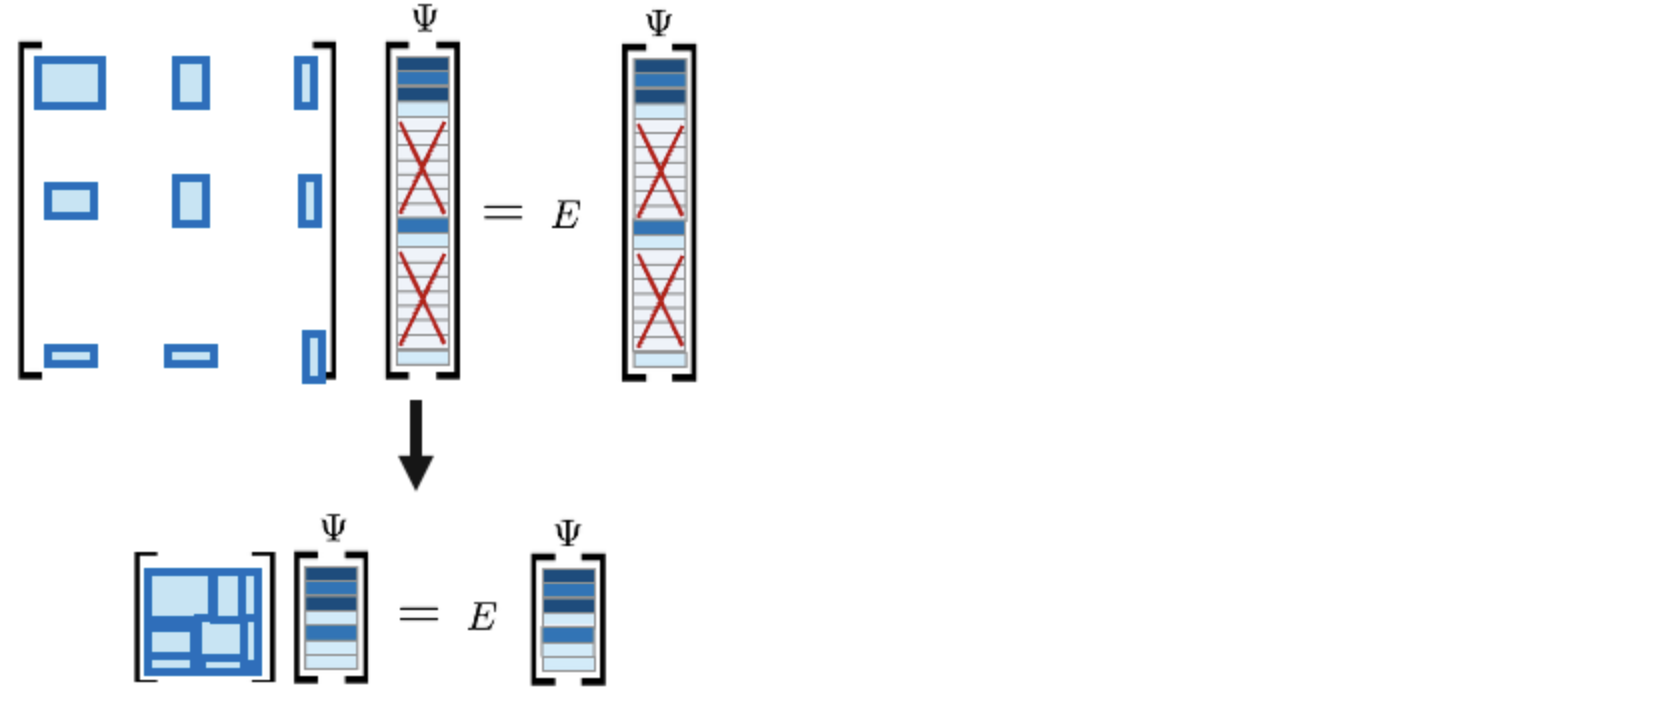

Fig 3. An illustration of the original Hamiltonian shown as an exponentially large matrix in the Hilbert space of N qubits then reduced to a smaller size after configuration recovery and subsampling.


Let's say we have three atomic orbitals 1s, 2p, 3d, and two electrons that can occupy these orbitals that are ranked from low to high energy. Low energy configurations mean most electrons occupy the lower orbitals while high energy configurations will have electrons in the higher orbitals. 
One of the important assumptions of the SQD algorithm is that high-energy configurations will have little contributions to the ground state. This allows us to remove these less relevant configurations so we can focus on a subspace of relevant configurations only - in our case configurations that show occupancies of electrons in the lower orbitals. 

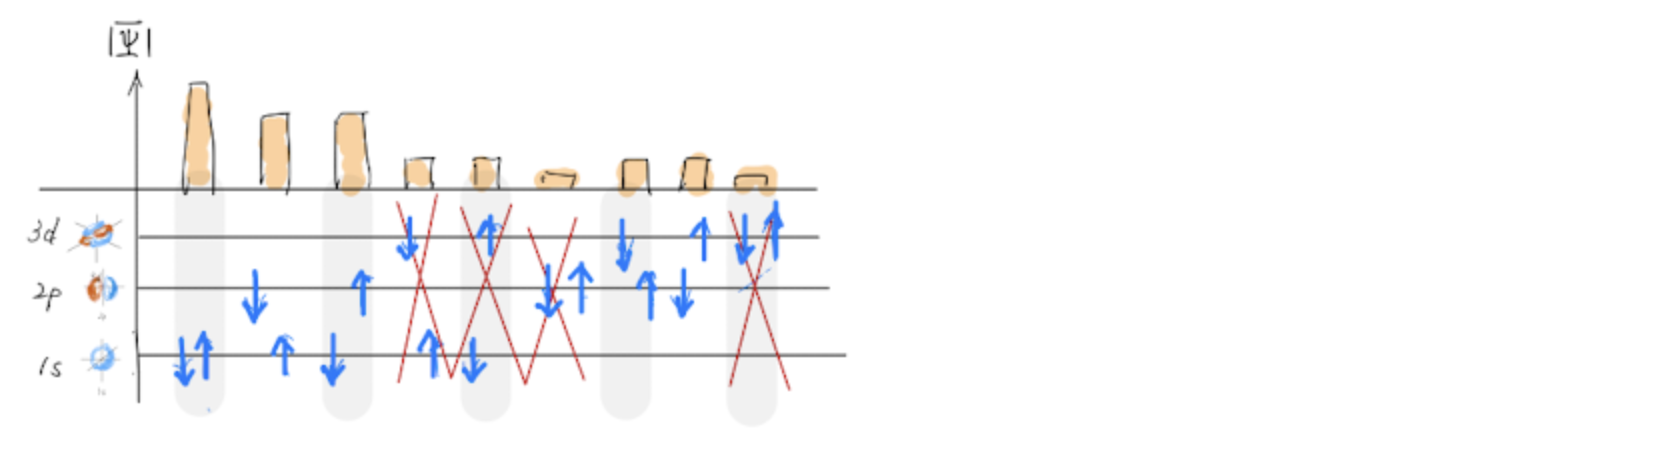

Fig 4. Removing electron configurations that are not relevant to the ground state allows us to reduce the size of the matrix (Hamiltonian)


This reconstruction of Hamiltonian to a smaller size significantly reduces the time to arrive at the solution. 

## Choosing relevant configurations

For identifying the relevant electron configuration, we use a quantum circuit (ansatz) denoted by $|\psi\rangle$ in this illustration, which upon measurement in the computational basis will give us a probability distribution over the Hilbert space to sample necessary bitstrings from. 

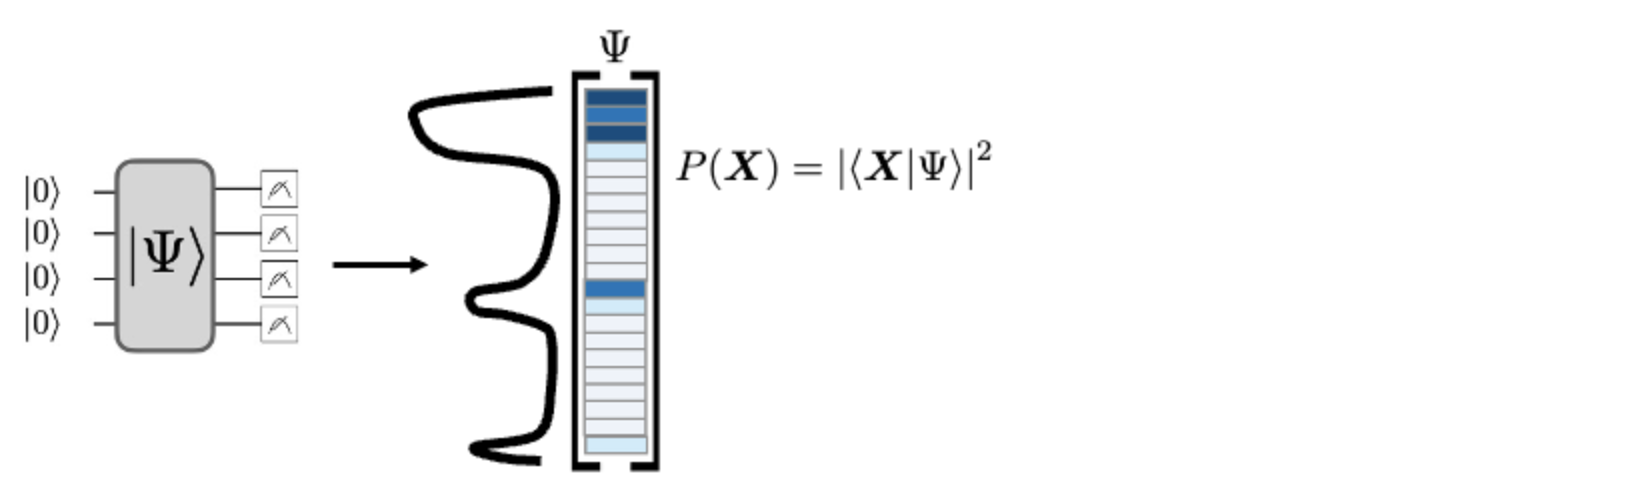

Fig 5. A quantum 'ansatz' circuit will produce the bitstrings we sample from

## Dealing with the effects of noise with configuration recovery

Before we subsample from the pool of bitstrings generated by the quantum circuit, we need to deal with 'noisy quantum samples' that may affect the accuracy of our energy calculations. This is where configuration recovery comes into play.  Let's say we have a bitstring that is missing one electron from its configuration. This is easy to identify as the hamming weight is wrong. We can also exploit the expectation of occupancies in the different orbitals (given by 'n' in the illustration below) to determine which bit to flip to correct the bitstrings.

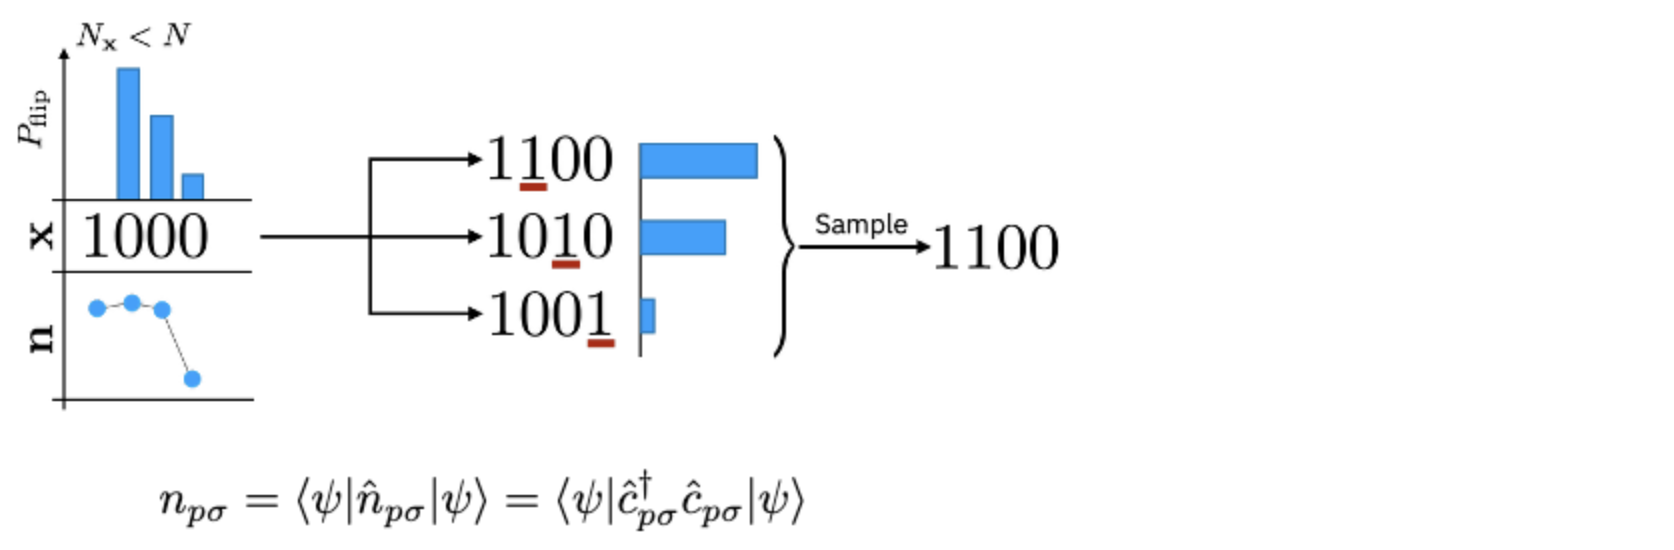

Fig 6. By looking at the electron numbers and occupancy expectation, we can determine which bit to flip

Having reconstructed your Hamiltonian with good samples, you now have a reduced size matrix to diagonalize. Upon diagonalizing the Hamiltonian in the subspace, what the diagonalization subroutine does is assign a non-zero wavefunction amplitude to the computational basis states that contribute to the ground state of the problem. The same routine will assign a zero weight to those bit strings that do not represent the ground state. From the results of all batches, the SQD algorithm obtains the orbital occupancy by electrons and lowest energy estimation and updates the data for the next configuration recovery loop.

# 4. How to simulate an $N_2$ molecule with SQD

In this section, we will demonstrate how to post-process noisy quantum samples to find an approximation to the ground state of a chemistry Hamiltonian: the $N_2$ molecule at equilibrium in the 6-31G basis set. We will follow a SQD approach to process samples taken from a 36-qubit quantum circuit ansatz (in this case, an LUCJ circuit). In order to account for the effect of quantum noise, the configuration recovery technique is used.

## Molecular Hamiltonian

The properties of molecules are largely determined by the structure of the electrons within them. As fermionic particles, electrons can be described using a mathematical formalism called second quantization. The idea is that there are a number of *orbitals*, each of which can be either empty or occupied by a fermion. A system of $N$ orbitals is described by a set of fermionic annihilation operators $\{\hat{a}_p\}_{p=1}^N$ that satisfy the fermionic anticommutation relations,

$$
\begin{align*}
\hat{a}_p \hat{a}_q + \hat{a}_q \hat{a}_p &= 0, \\
\hat{a}_p \hat{a}_q^\dagger + \hat{a}_q^\dagger \hat{a}_p &= \delta_{pq}.
\end{align*}
$$

The adjoint $\hat{a}_p^\dagger$ is called a creation operator.

So far, our exposition has not accounted for spin, which is a fundamental property of fermions. When accounting for spin, the orbitals come in pairs called *spatial orbitals*. Each spatial orbital is composed of two *spin orbitals*, one that is labeled "spin-$\alpha$" and one that is labeled "spin-$\beta$". We then write $\hat{a}_{p\sigma}$ for the annihilation operator associated with the spin-orbital with spin $\sigma$ ($\sigma \in \{\alpha, \beta\}$) in spatial orbital $p$. If we take $N$ to be the number of spatial orbitals, then there are a total of $2N$ spin-orbitals. The Hilbert space of this system is spanned by $2^{2N}$ orthonormal basis vectors labeled with two-part bitstrings $\lvert z \rangle = \lvert z_\beta z_\alpha \rangle = \lvert z_{\beta, N} \cdots z_{\beta, 1} z_{\alpha, N} \cdots z_{\alpha, 1} \rangle$.

The Hamiltonian of a molecular system can be written as

$$
\hat{H} = \sum_{ \substack{pr\\\sigma} } h_{pr} \, \hat{a}^\dagger_{p\sigma} \hat{a}_{r\sigma}
+ \frac12
\sum_{ \substack{prqs\\\sigma\tau} }
h_{prqs} \, 
\hat{a}^\dagger_{p\sigma}
\hat{a}^\dagger_{q\tau}
\hat{a}_{s\tau}
\hat{a}_{r\sigma},
$$

where the $h_{pr}$ and $h_{prqs}$ are complex numbers called molecular integrals that can be calculated from the specification of the molecule using a computer program. In this tutorial, we compute the integrals using the [PySCF](https://pyscf.org/) software package.

For details about how the molecular Hamiltonian is derived, consult a textbook on quantum chemistry (for example, *Modern Quantum Chemistry* by Szabo and Ostlund). 

## Local unitary cluster Jastrow (LUCJ) ansatz

SQD requires a quantum circuit ansatz to draw samples from. In this lab, we'll use the [local unitary cluster Jastrow (LUCJ)](https://pubs.rsc.org/en/content/articlelanding/2023/sc/d3sc02516k) ansatz [1] due to its combination of physical motivation and hardware-friendliness.

The LUCJ ansatz is a specialized form of the general unitary cluster Jastrow (UCJ) ansatz, which has the form

$$
  \lvert \Psi \rangle = \prod_{\mu=1}^L e^{\hat{K}_\mu} e^{i \hat{J}_\mu} e^{-\hat{K}_\mu} | \Phi_0 \rangle
$$

where $\lvert \Phi_0 \rangle$ is a reference state, often taken to be the Hartree-Fock state, and the $\hat{K}_\mu$ and $\hat{J}_\mu$ have the form

$$
\hat{K}_\mu = \sum_{pq, \sigma} K_{pq}^\mu \, \hat{a}^\dagger_{p \sigma} \hat{a}^{\phantom{\dagger}}_{q \sigma}
\;,\;
\hat{J}_\mu = \sum_{pq, \sigma\tau} J_{pq,\sigma\tau}^\mu \, \hat{n}_{p \sigma} \hat{n}_{q \tau}
\;,
$$

where we have defined the number operator

$$
\hat{n}_{p \sigma} = \hat{a}^\dagger_{p \sigma} \hat{a}^{\phantom{\dagger}}_{p \sigma}.
$$

The operator $e^{\hat{K}_\mu}$ is an orbital rotation, which can be implemented using known algorithms in linear depth and using linear connectivity.
Implementing the $e^{i \mathcal{J}_k}$ term of the UCJ ansatz requires either all-to-all connectivity or the use of a fermionic swap network, making it challenging for noisy pre-fault-tolerant quantum processors that have limited connectivity. The idea of the *local* UCJ ansatz is to impose sparsity constraints on the
$\mathbf{J}^{\alpha\alpha}$ and $\mathbf{J}^{\alpha\beta} $
matrices which allow them to be implemented in constant depth on qubit topologies with limited connectivity. (Here, $\mathbf{J}^{\alpha\alpha}= J_{p q,\alpha\alpha}^1$ and $\mathbf{J}^{\alpha\beta}= J_{p q,\alpha\beta}^1$.)

The IBM hardware has a heavy-hex lattice qubit topology, in which case we can adopt a "zigzag" pattern, depicted below. In this pattern, orbitals with the same spin are mapped to qubits with a line topology (red and blue circles), and a connection between orbitals of different spin is present at every 4th spatial orbital, with the connection being facilitated by an ancillary qubit (purple circles). In this case, the index constraints are

$$
\begin{align*}
\mathbf{J}^{\alpha\alpha} &: \{(p, p+1) \; , \; p = 0, \ldots, N-2\} \\
\mathbf{J}^{\alpha\beta} &: \{(p, p) \;, \; p = 0, 4, 8, \ldots,\; p \leq N-1\}
\end{align*}
$$




Fig 7. IBM's quantum hardware with a heavy-hex lattice qubit topology

## Sample-based Quantum Diagonalization (SQD)

The self-consistent configuration recovery procedure is designed to extract as much signal as possible from noisy quantum samples. The procedure is run in a loop, and each iteration has the following steps:

1. **Recover the configuration**: For each bitstring that violates the specified symmetries, flip its bits with a probabilistic procedure designed to bring the bitstring closer to the current estimate of the average orbital occupancies, to obtain a new bitstring.
2. **Subsample**: Collect all of the old and new bitstrings that satisfy the symmetries, and subsample subsets of a fixed size, chosen in advance.
3. **Diagonalize in subspace**: For each subset of bitstrings, project the Hamiltonian into the subspace spanned by the corresponding basis vectors and compute a ground state estimate of the projected Hamiltonian on a classical computer.
4. **Find the lowest energy**: Update the estimate of the average orbital occupancies with the ground state estimate with the lowest energy.

The SQD workflow is depicted in the following diagram:


Fig 8. A diagram showing the SQD workflow

SQD is known to work well when the target eigenstate is sparse: the wave function is supported in a set of basis states $\mathcal{S} = \{|x\rangle \}$ whose size does not increase exponentially with the size of the problem.

### Configuration recovery loop 1: Recover the configuration

The first step in the configuration recovery loop is to recover the configuration. In other words, error mitigation is performed in this part.

If you run the quantum circuit that is the LUCJ ansatz built above on a quantum computer, you will get a bitstring and its count number as shown in the figure on the lower left. Because current noisy quantum computers give the result with the errors. Since the particle number of "spin-$\alpha$" and "spin-$\beta$" of the molecule in problem is fixed, we will correct the error by flipping a part of the resulting bitstring so that the particle number is stored correctly.

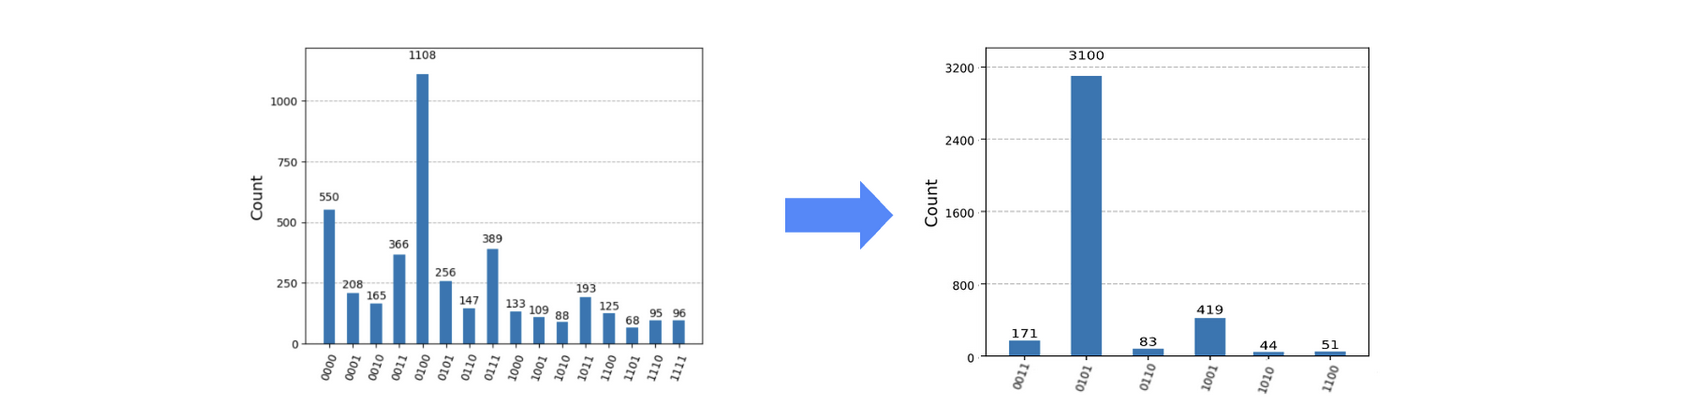

Fig 9. Bitstrings that are initially produced by the LUCJ ansatz circuit (left) and the corrected bitstrings (right)

For example, let's think about a problem that considers up to four spin orbitals for a molecule with two "spin-$\alpha$" and two "spin-$\beta$". If the orbitals are filled from the bottom of energy levels, the quantum state is |0011 0011> as shown in the figure on the lower left.
If the result of running the quantum computer contains |1110 0011> then three "spin-$\beta$" is too many, so one of the bits is flipped from 1 to 0 so that there are two.
Also, if |0011 0001> is observed, one "spin-$\alpha$" is missing, so one of these three electrons is inverted from 0 to 1.

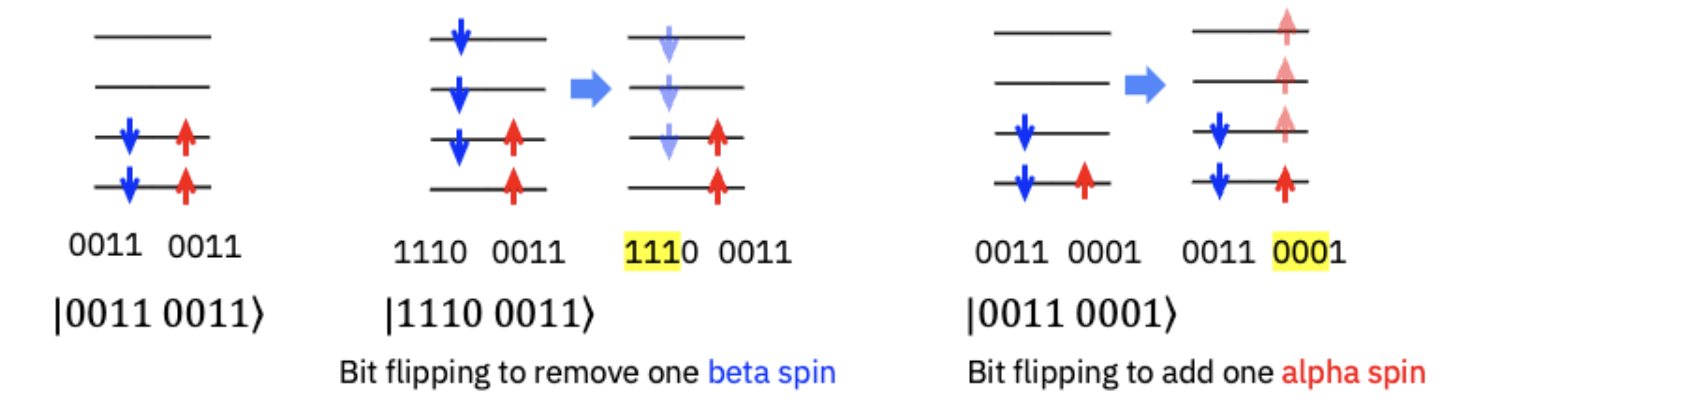

Fig 10. The strings are being corrected based on electron numbers and occupancy expectation with maxim weighted probability

At this time, when choosing which electron to be flipped, the average orbital occupancy is used and flip the bit with the maximum weighted probability of flipping.
The average orbital occupancy is calculated at the end of the configuration recovery loop. So, in the first loop, we don't do this because we don't have an average orbital occupancy, and we discard the sample with the wrong particle numbers.

### Configuration recovery loop 2: Subsample

The next step is to select some from the corrected samples.
This time, we have 100,000 shots, so for example, we randomly select 50 samples from these 5 times, that is, 5 batches. When handling large molecules in batches, this part can be computed in parallel on a supercomputer.

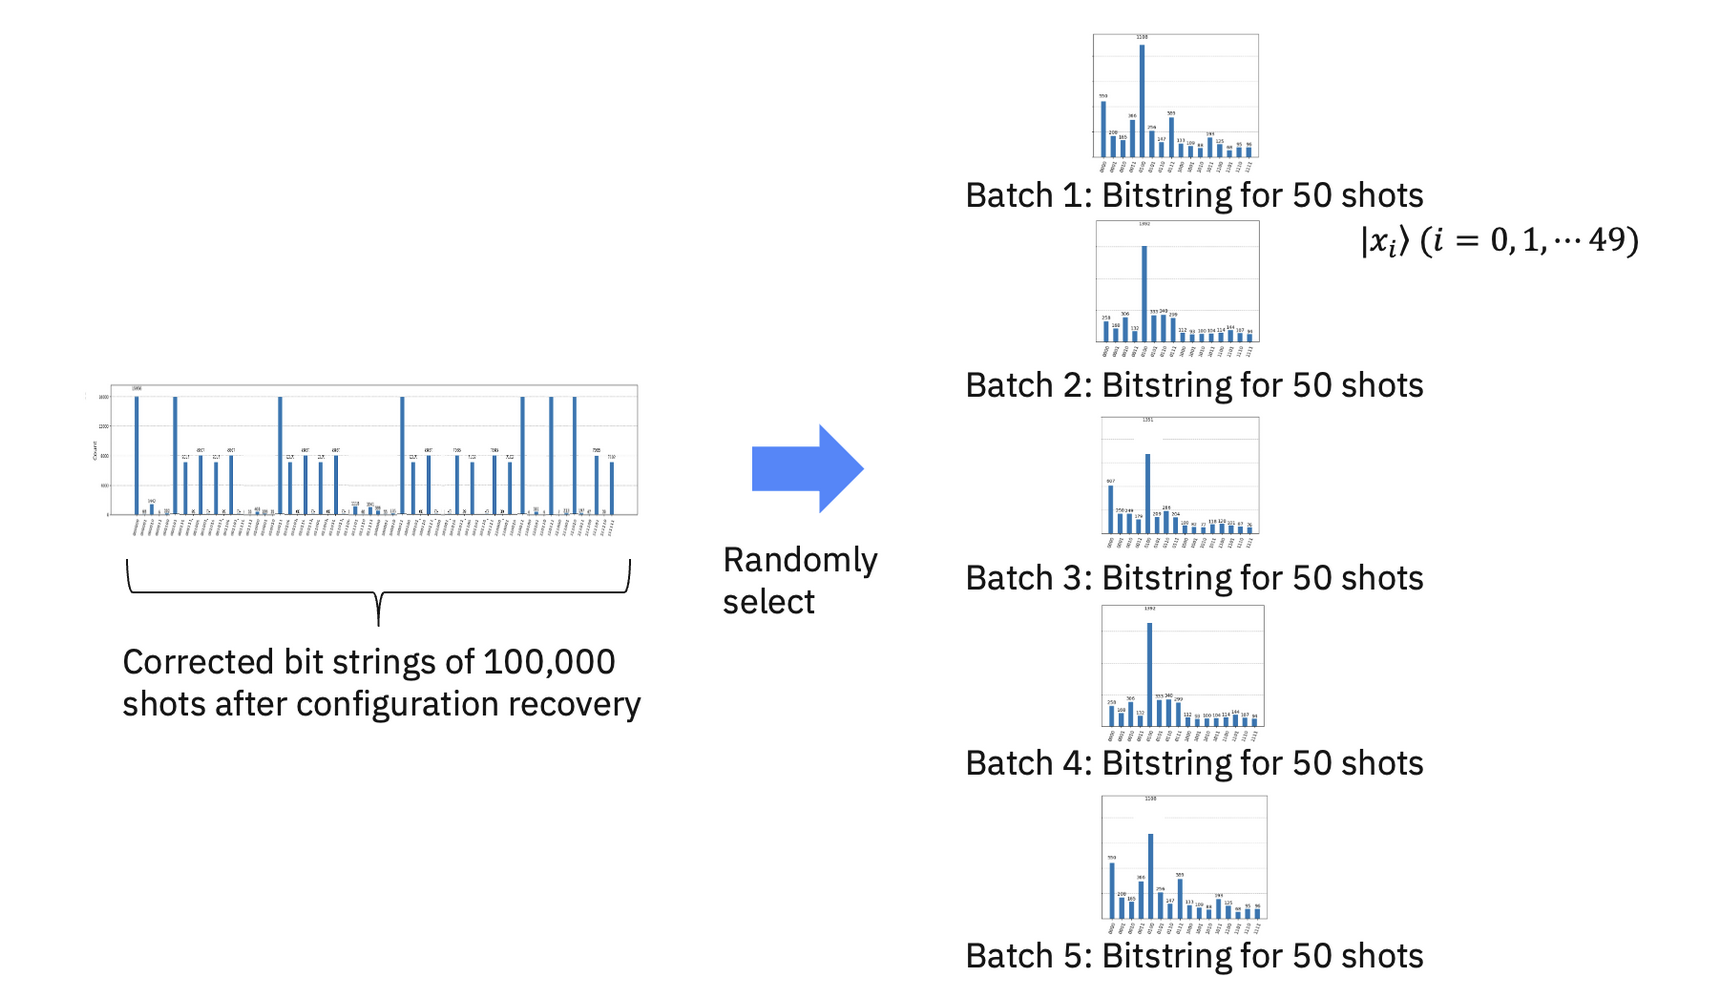

Fig 11. Subsampling from corrected samples

### Configuration recovery loop 3: Diagonalize in subspace

Next is diagonalizing in subspace. In the previous example, the original Hamiltonian $H$, $2^{32}\times2^{32}$ matrix, is projected into the subspace created by $50$ bitstrings, $|x_i\rangle$, and diagonalized.
This projection matrix $P_S$ can have $2^{32}$ different measured bitstrings, from 0...0 to 1...1, but a maximum of $50$ bitstrings can be measured. $P_S$ is a matrix with only $50$ diagonal components and the rest of the matrix with $0$. Therefore, by multiplying $P_S$ by the original Hamiltonian $H$, the projected Hamiltonian $H_s$ has only $50\times50$ components and all other elements are 0. So, we can diagonalize only $50\times50$ matrix instead of the original huge $2^{32}\times2^{32}$ matrix.

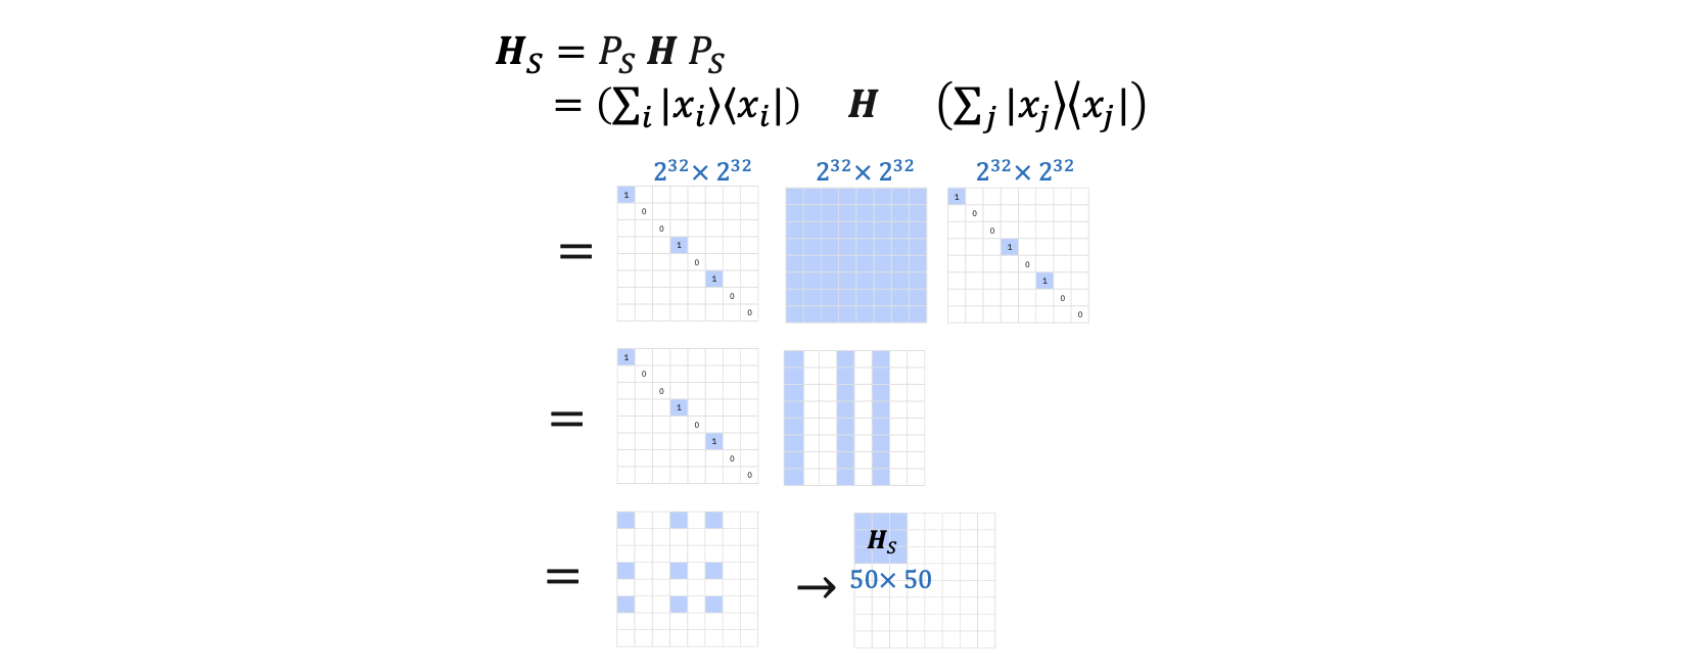

Fig 12. Matrix diagonalization in the subspace

### Configuration recovery loop 4: Find the lowest energy

Finally, from the results of all batches, we obtain an estimate of the average orbital occupancy, and the lowest energy as an estimate of the ground state. And update these data.

## Qiskit patterns

We implement a Qiskit patterns showing how SQD process:

1. **Step 1: Map to quantum problem**
    - Generate an ansatz for estimating the ground state
2. **Step 2: Optimize the problem**
    - Transpile the ansatz for the backend
3. **Step 3: Execute experiments**
    - Draw samples from the ansatz using the ``Sampler`` primitive
4. **Step 4: Post-process results**
   - Self-consistent configuration recovery loop
       - Post-process the full set of bitstring samples, using prior knowledge of particle number and the average orbital occupancy calculated on the most recent iteration.
       - Probabilistically create batches of subsamples from recovered bitstrings.
       - Project and diagonalize the molecular Hamiltonian over each sampled subspace.
       - Save the minimum ground state energy found across all batches and update the avg orbital occupancy.


## Step 1: Map classical inputs to a quantum problem

We will find an approximation to the ground state of the molecule at equilibrium in the 6-31G basis set. First, we specify the molecule and its properties.


In [15]:
warnings.filterwarnings("ignore")

# Specify molecule properties
open_shell = False
spin_sq = 0

# Build N2 molecule
mol = pyscf.gto.Mole()
mol.build(
    atom=[["N", (0, 0, 0)], ["N", (1.0, 0, 0)]],
    basis="6-31g",
    symmetry="Dooh",
)

# Define active space
n_frozen = 2
active_space = range(n_frozen, mol.nao_nr())

# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
num_orbitals = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

# Compute exact energy
exact_energy = cas.run().e_tot

converged SCF energy = -108.835236570775
CASCI E = -109.046671778080  E(CI) = -32.8155692383188  S^2 = 0.0000000
CASCI E = -109.046671778080  E(CI) = -32.8155692383188  S^2 = 0.0000000


Before constructing the `LUCJ` ansatz circuit, we first perform a CCSD calculation in the following code cell. The [$t_1$ and $t_2$ amplitudes](https://en.wikipedia.org/wiki/Coupled_cluster#Cluster_operator) from this calculation will be used to initialize the parameters of the ansatz.

In [16]:
# Get CCSD t2 amplitudes for initializing the ansatz
ccsd = pyscf.cc.CCSD(scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]).run()
t1 = ccsd.t1
t2 = ccsd.t2

E(CCSD) = -109.0398256929734  E_corr = -0.2045891221988315


Now, we use [ffsim](https://github.com/qiskit-community/ffsim) to create the ansatz circuit. Since our molecule has a closed-shell Hartree-Fock state, we use the spin-balanced variant of the UCJ ansatz, [UCJOpSpinBalanced](https://qiskit-community.github.io/ffsim/api/ffsim.html#ffsim.UCJOpSpinBalanced). We pass interaction pairs appropriate for a heavy-hex lattice qubit topology.

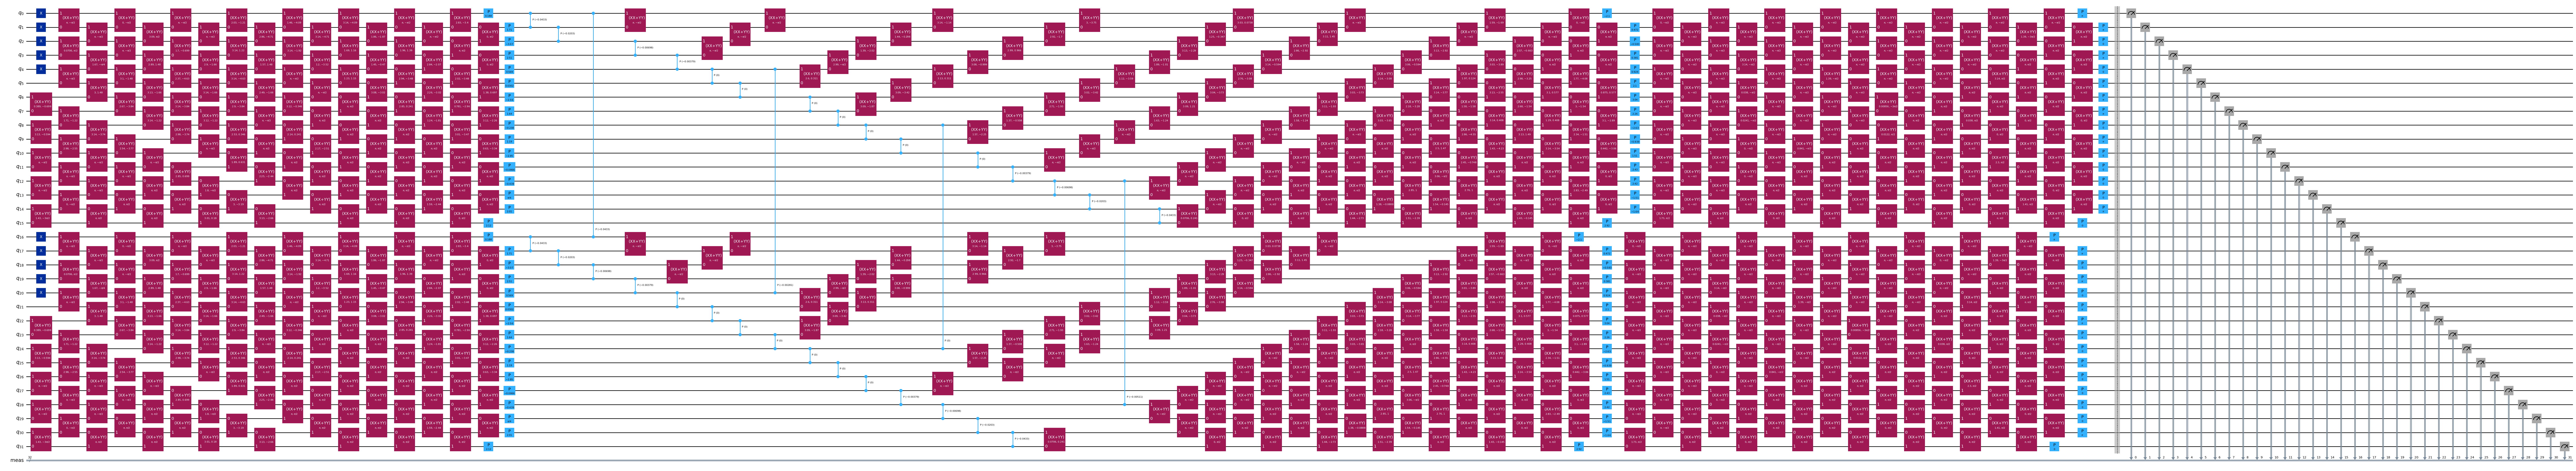

In [17]:
n_reps = 1
alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)]
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]

ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
)

nelec = (num_elec_a, num_elec_b)

# create an empty quantum circuit
qubits = QuantumRegister(2 * num_orbitals, name="q")
circuit = QuantumCircuit(qubits)

# prepare Hartree-Fock state as the reference state and append it to the quantum circuit
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)

# apply the UCJ operator to the reference state
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit.measure_all()

circuit.decompose().decompose().draw("mpl", fold =-1)

## Step 2: Optimize problem for quantum execution
Next, we optimize the circuit for a target hardware. We'll use the 127-qubit `ibm_brisbane` QPU.

In [18]:
service = QiskitRuntimeService(name="qgss-2025")
backend = service.backend("ibm_brisbane")

We recommend the following steps to optimize the ansatz and make it hardware-compatible.

* Select physical qubits (`initial_layout`) from the target hardware that adheres to the zig-zag pattern described above. Laying out qubits in this pattern leads to an efficient hardware-compatible circuit with less gates.
* Generate a staged pass manager using the [generate\_preset\_pass\_manager](https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.transpiler.generate_preset_pass_manager) function from qiskit with your choice of `backend` and `initial_layout`.
* Set the `pre_init` stage of your staged pass manager to `ffsim.qiskit.PRE_INIT`. `ffsim.qiskit.PRE_INIT` includes qiskit transpiler passes that decompose gates into orbital rotations and then merges the orbital rotations, resulting in fewer gates in the final circuit.
* Run the pass manager on your circuit.


In [19]:
spin_a_layout = [0, 14, 18, 19, 20, 33, 39, 40, 41, 53, 60, 61, 62, 72, 81, 82]
spin_b_layout = [2, 3, 4, 15, 22, 23, 24, 34, 43, 44, 45, 54, 64, 65, 66, 73]
initial_layout = spin_a_layout + spin_b_layout

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend, initial_layout=initial_layout
)

# We will use the circuit generated by this pass manager for hardware execution
pass_manager.pre_init = ffsim.qiskit.PRE_INIT
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/ pre-init passes): {isa_circuit.count_ops()}")

Gate counts (w/ pre-init passes): OrderedDict([('rz', 2451), ('sx', 2127), ('ecr', 730), ('x', 84), ('measure', 32), ('barrier', 1)])


## Step 3: Execute using Qiskit Primitives

After optimizing the circuit for hardware execution, we are ready to run it on the target hardware and collect samples for ground state energy estimation. 

<div class="alert alert-block alert-warning">
    
⚠️ **Note:** We have commented out the code for running the circuit on a QPU and left it for the user's reference. Instead of running on real hardware in this walkthrough, we will just read in 100k samples drawn from ``ibm_brisbane`` at an earlier time.

</div>

In [20]:
# from qiskit_ibm_runtime import SamplerV2 as Sampler

# sampler = Sampler(mode=backend)
# job = sampler.run([isa_circuit], shots=10_000)
# primitive_result = job.result()
# pub_result = primitive_result[0]
# bit_array = pub_result.data.meas

bit_array = np.load('utils/N2_device_bitarray.npy', allow_pickle=True).item()

## Step 4: Post-process and return result to desired classical format

Recall that the self-consistent configuration recovery is an iterative procedure that runs in a loop. In the following code cell, the first iteration of the loop simply uses the raw samples (after post-selection on symmetries) as input to the diagonalization procedure to obtain an estimate of the average orbital occupancies. Later iterations of the loop use these occupancies to generate new configurations from raw samples that violate the symmetries. These configurations are collected and then subsampled to produce batches of configurations, which are then used to project the Hamiltonian and compute a ground state estimate with an eigenstate solver.

There are a few user-controlled options which are important for this technique:

* `max_iterations`: Number of iterations of the self-consistent recovery loop.
* `num_batches`: Number of batches of configurations to subsample (this will be the number of separate calls to the eigenstate solver)
* `samples_per_batch`: Number of unique configurations to include in each batch
* `max_cycles`: Maximum number of Davidson cycles run by the eigenstate solver


<div class="alert alert-block alert-warning">
<b>Warning: 5 minutes needed</b>

When running the code below it will take up to 5 minutes (depending on your computer) to execute and will block this notebook for this time. 

</div>

In [ ]:
%%time
# SQD options
energy_tol = 1e-3  
occupancies_tol = 1e-3 
max_iterations = 5

# Eigenstate solver options
num_batches = 5
samples_per_batch = 50
symmetrize_spin = True 
carryover_threshold = 1e-4 
max_cycle = 200
rng = np.random.default_rng(24)


# Pass options to the built-in eigensolver. If you just want to use the defaults,
# you can omit this step, in which case you would not specify the sci_solver argument
# in the call to diagonalize_fermionic_hamiltonian below.
sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=max_cycle)


# List to capture intermediate results
result_history = [] 

def callback(results: list[SCIResult]): 
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        print(f"\t\tEnergy: {result.energy + nuclear_repulsion_energy}")
        print(f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}")

result = diagonalize_fermionic_hamiltonian(
    hcore,
    eri,
    bit_array,
    samples_per_batch=samples_per_batch,
    norb=num_orbitals,
    nelec=nelec,
    num_batches=num_batches,
    energy_tol=energy_tol,
    occupancies_tol=occupancies_tol,
    max_iterations=max_iterations,
    sci_solver=sci_solver,
    symmetrize_spin=symmetrize_spin,
    carryover_threshold=carryover_threshold,
    callback=callback,
    seed=rng,
)

Iteration 1
	Subsample 0
		Energy: -106.27329013141701
		Subspace dimension: 10000
	Subsample 1
		Energy: -105.43810831755857
		Subspace dimension: 9801
	Subsample 2
		Energy: -106.6376942596939
		Subspace dimension: 10000
	Subsample 3
		Energy: -106.61258013830128
		Subspace dimension: 9801
	Subsample 4
		Energy: -106.63164450395638
		Subspace dimension: 9801
Iteration 2
	Subsample 0
		Energy: -107.9108490741182
		Subspace dimension: 9409
	Subsample 1
		Energy: -108.84006034736296
		Subspace dimension: 9604
	Subsample 2
		Energy: -108.8415045767002
		Subspace dimension: 10000
	Subsample 3
		Energy: -107.912900848716
		Subspace dimension: 9409
	Subsample 4
		Energy: -108.84031227231546
		Subspace dimension: 9216
Iteration 2
	Subsample 0
		Energy: -107.9108490741182
		Subspace dimension: 9409
	Subsample 1
		Energy: -108.84006034736296
		Subspace dimension: 9604
	Subsample 2
		Energy: -108.8415045767002
		Subspace dimension: 10000
	Subsample 3
		Energy: -107.912900848716
		Subspace dimen

## Visualize the results

To see the result, we first create a function `plot_energy_and_occupancy`.


In [ ]:
def plot_energy_and_occupancy(result_history, exact_energy):
    # ---- TODO : Task 1 ---
    # Create a function to plot SQD convergence progress 
    # Plot 1: Energy error vs iteration
    # Plot 2: Average spatial orbital occupancy
    
    # Prepare data for plotting
    x1 = range(len(result_history))
    
    # Calculate minimum energy for each iteration
    min_e = [
        min(result, key=lambda res: res.energy).energy + nuclear_repulsion_energy
        for result in result_history
    ]
    e_diff = [abs(e - exact_energy) for e in min_e]
    yt1 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4]
    
    # Chemical accuracy (+/- 1 milli-Hartree)
    chem_accuracy = 0.001
    
    # Get final result for orbital occupancy
    result = result_history[-1]
    
    # Data for avg spatial orbital occupancy
    y2 = np.sum(result.orbital_occupancies, axis=0)
    x2 = range(len(y2))
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot 1: Energy error vs iteration (logarithmic scale)
    axs[0].semilogy(x1, e_diff, 'o-', label='Energy Error')
    axs[0].axhline(y=chem_accuracy, color='r', linestyle='--', 
                   label='Chemical Accuracy (1 mHa)')
    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Energy Error (Ha)')
    axs[0].set_title('SQD Energy Convergence')
    axs[0].legend()
    axs[0].grid(True, alpha=0.3)
    axs[0].set_xticks(x1)
    axs[0].set_yticks(yt1)
    axs[0].set_yscale("log")
    axs[0].set_ylim(1e-4)
    axs[0].axhline(y=chem_accuracy, color="#BF5700", linestyle="--", label="chemical accuracy")
    axs[0].set_title("Approximated Ground State Energy Error vs SQD Iterations")
    axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
    axs[0].set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
    axs[0].legend()
    
    # Plot orbital occupancy
    axs[1].bar(x2, y2, width=0.8)
    axs[1].set_xticks(x2)
    axs[1].set_xticklabels(x2)
    axs[1].set_title("Avg Occupancy per Spatial Orbital")
    axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
    axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})
    
    plt.tight_layout()
    plt.show()
    # --- End of TODO ---

In [ ]:
plot_energy_and_occupancy(result_history, exact_energy)

The first plot shows that after a couple of iterations we estimate the ground state energy within `~100 mH` (chemical accuracy is typically accepted to be `1 kcal/mol` $\approx$ `1.6 mH`). The energy can be improved by drawing more samples from the circuit or increasing the number of samples per batch.

The second plot shows the average occupancy of each spatial orbital after the final iteration. We can see that both the spin-up and spin-down electrons occupy the first five orbitals with high probability in our solutions.

<a id="exercise_2"></a>
<div class="alert alert-block alert-success">
    
<b>Exercise 2: Flip a bit by configuration recovery</b> 

In a problem in which an $N_2$ molecule is prepared using the STO-3G basis set, we perform configuration recovery. When the average orbital occupancy $n$ is as follows, we will correct the bitstring $x$ as follows. What bitstring is most likely to be modified to?

$n = [0.007, 0.029, 0.029, 0.995, 
     0.976, 0.976, 0.993, 0.997, 
     0.007, 0.029, 0.029, 0.995,
     0.976, 0.976, 0.993, 0.997]$

$x = [1, 0, 0, 0,  1, 0, 1, 1,  1, 0, 1, 1,  1, 1, 0, 0]$

A weighted probability of flipping $w(y)$ using a modified ReLU function is calculated as follows from [2]. 
$$
\begin{align}
    w(y) = \begin{cases} 
    \delta\cdot \frac{y}{h} & \text{if }  y \leq h\\ 
    \delta + (1 - \delta)\cdot \frac{y - h}{1 - h} & \text{if } y > h
\end{cases}
\end{align}
$$ 

Here, $y$ is a probability of flipping, and defined as $y[i] =|x[i]-n[i]|$ for the $i$ -th spin orbital. $h$ defines the location of the "corner" of the ReLU function, and the parameter $\delta$ defines the value of the ReLU function at the corner. We use $\delta = 0.01$, same as [2], and $h = $number of alpha(or beta) particles$/$number of alpha(or beta) spin orbitals$ = N/M$ (filling factor).

In the actual configuration recovery, a bit is randomly inverted with a weight of $w(y)$. In this exercise, answer the result of inverting the bit $i$ with the largest $w(y[i])$ as the bitstring with the highest probability of obtaining.


Note: 
- The right half of a bitstring represents spin-up orbitals, and the left half represents spin-down orbitals. A `1` means the orbital is occupied by an electron, and a `0` means the orbital is empty.
- Please refer to the section ["4.1 Configuration recovery overview" in Lesson 4: SQD application](https://quantum.cloud.ibm.com/learning/en/courses/quantum-diagonalization-algorithms/sqd-implementation) of "Quantum Diagonalization Algorithm" of IBM Quantum Learning.
- In this case, one more beta particle is needed, so if the i-th orbital is already occupied and need not to be flipped, you set its y_beta[i] to 0.

In [ ]:
n = [0.007, 0.029, 0.029, 0.995, 
     0.976, 0.976, 0.993, 0.997, 
     0.007, 0.029, 0.029, 0.995,
     0.976, 0.976, 0.993, 0.997]

x = [1, 0, 0, 0,  1, 0, 1, 1,  1, 0, 1, 1,  1, 1, 0, 0]

In [ ]:
x = np.array(x)
n = np.array(n)

# ---- TODO : Task 2 ---

# Divide into alpha spin and beta spin
x_alpha =
x_beta =

# probability of flipping
y = 
y_alpha =
y_beta =

# In this case, one more beta particle is needed, so set y_beta[i] to 0 if x_beta[i] is already 1. 
for i in range(len(y_beta)):


# --- End of TODO ---

print(y_beta)

In [ ]:
h = 5/8
delta = 0.01
w = np.zeros(len(y_beta))

# find the maximum w
# ---- TODO : Task 2 ---
for i in range(len(y_beta)):


# --- End of TODO ---
# print(max_index, max_w)

In [ ]:
# Flip the bit of the index with the largest w
# ---- TODO : Task 2 ---
for i in range(len(y_beta)):



x = np.concatenate([x_beta, x_alpha])
corrected_x = 
# --- End of TODO ---
# print(corrected_x)

In [ ]:
# Submit your answer using following code

grade_lab3_ex2(corrected_x) # Expected result type: list

# 5. Improve the ansatz

The more accurate the sampling from the quantum circuit, the better the results. Therefore, how to make the ansatz for sampling is one of the key points in SQD performance. Depending on how the ansatz is set, different bit strings are sampled, which affects the accuracy of the energy estimate value that can be obtained. Here, we will explore the different ansatz to improve the result.

## 5.1 Change basis set

First, let's try to model the molecule in a more natural way by changing the basis set of the molecule to account for more electron orbitals. Incorporating more orbitals into the calculation will increase the computational complexity, but should lower the value of the energy estimation.

<a id="exercise_3"></a>
<div class="alert alert-block alert-success">
    
<b>Exercise 3: Change basis set</b> 

Change the basis set from `6-31G` to `cc-pvdz`. How many qubits are needed if we use the LUCJ ansatz with **6** ancillary qubits in case we use `ibm_torino` as a backend?     
Note: Because of the geometric limitation of `ibm_torino`, the number of ancillary qubits is limited to 6 here.

</div>

In [ ]:
warnings.filterwarnings("ignore")

# Specify molecule properties
open_shell = False
spin_sq = 0

# Build N2 molecule
mol = pyscf.gto.Mole()
mol.build(
    atom=[["N", (0, 0, 0)], ["N", (1.0, 0, 0)]],
    # ---- TODO : Task 3 ---
    basis= ### input your code here ###,
    # --- End of TODO ---
    symmetry="Dooh",
)

# Define active space
n_frozen = 2
active_space = range(n_frozen, mol.nao_nr())

# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
num_orbitals = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

print(num_orbitals)

In [ ]:
# ---- TODO : Task 2 ---
# Create a Sampler with options (See documentation for possible options) 
sampler = Sampler(backend=backend, options={"execution": {"shots": 10000}})
# --- End of TODO ---

In [ ]:
# ---- TODO : Task 2 ---
# Use the sampler to collect quantum samples
job = sampler.run([isa_circuit])
samples = job.result()[0].data.c.get_counts()
# --- End of TODO ---

# ---- TODO : Task 2 ---
# Convert the samples to array format
# The samples dict maps bit strings to their counts
samples_array = []
for bit_string, count in samples.items():
    # Convert bit string to array of ints
    bit_array = [int(bit) for bit in bit_string]
    # Add this sample 'count' times to the array
    for _ in range(count):
        samples_array.append(bit_array)

samples_array = np.array(samples_array)

print(f"Total number of samples: {len(samples_array)}")
print(f"Sample shape: {samples_array.shape}")
print(f"First 5 samples:")
for i in range(min(5, len(samples_array))):
    print(f"  Sample {i+1}: {samples_array[i]}")
# --- End of TODO ---

<a id="exercise_4"></a>
<div class="alert alert-block alert-success">
    
<b>Exercise 4: Select the best layout</b> 

Which qubits should we choose as the initial placement to get the best results? To select the qubits, you need to check the errors of each qubit. In the following map, qubits with a readout error greater than 0.1 are shown in black, and edges with a CZ error greater than 0.1 are shown in white. Answer the best `initial_layout`, which is used as an argument of pass_manger to create the ISA circuit.    
We will use `ibm_torino` as a backend. Because of the geometric limitation of `ibm_torino`, the number of ancillary qubits limit to 6 here.

Select the best initial qubit layout to get better sampling by following:
1. List the qubits with a readout error of 0.1 or more as `bad_readout_qubits` from `backend_target`.
2. List of edges with a CZ error of 0.1 or more as `bad_czgate_edges` from `backend_target`.
3. Display the coupling map with `bad_readout_qubits` in black and `bad_czgate_edges` in white.
4. Select the best initial qubit layout.


</div>

<div class="alert alert-block alert-warning">
    
⚠️ **Note:** **You need to use the preloaded pickle file `backend_target_v20.pkl` or `backend_target_v21.pkl` as `backend_target` for backend information in order to pass the grader of this exercise**. In Lab 2, we used `backend.properties()`, `backend.target`, etc., but we won’t use them this time. We have commented out the code for a real backend a for the user's reference.  

</div>

In [ ]:
# from qiskit_ibm_runtime import QiskitRuntimeService
# service = QiskitRuntimeService(name="qgss-2025")
# backend = service.backend('ibm_torino') 
# backend_target = backend.target

In [ ]:
def callback(results: list[SCIResult]): 
    """Callback function to track SQD progress and plot results"""
    # ---- TODO : Task 3 ---
    # Complete the callback function
    # This function is called after each SQD iteration
    # Store the results and plot the progress
    
    result_history.append(results)
    
    print(f"Iteration {len(result_history)}")
    min_result = min(results, key=lambda res: res.energy)
    min_energy = min_result.energy + nuclear_repulsion_energy
    energy_error = abs(min_energy - exact_energy)
    
    print(f"  Minimum energy: {min_energy:.6f} Ha")
    print(f"  Energy error: {energy_error:.6e} Ha")
    print(f"  Number of results: {len(results)}")
    
    # Plot progress
    plot_energy_and_occupancy(result_history, exact_energy)
    # --- End of TODO ---

In [ ]:
# ---- TODO : Task 3 ---
# Initialize list to store results from each iteration
result_history = []
# --- End of TODO ---

<div class="alert alert-block alert-warning">
    
⚠️ **Note:** If you are using Qiskit version 2.1.x, open `backend_target_v21.pkl` in the next cell. 
</div>

In [ ]:
# for Qiskit version 2.0.x users
with open("utils/backend_target_v20.pkl", "rb") as f:
# for Qiskit version 2.1.x users
# with open("utils/backend_target_v21.pkl", "rb") as f:
    backend_target = pickle.load(f)

Note: Please refer ["Instruction properties" part of "Get QPU information with Qiskit"](https://quantum.cloud.ibm.com/docs/en/guides/get-qpu-information#instruction-properties) to get the properties like "measure" and "cz" from `backend_target`.

In [ ]:
BAD_READOUT_ERROR_THRESHOLD = 0.1
BAD_CZGATE_ERROR_THRESHOLD = 0.1
backend_num_qubits = 133

# ---- TODO : Task 4 ---
bad_readout_qubits = ### build your code here ###
bad_czgate_edges = ### build your code here ###
# --- End of TODO ---
print("Bad readout qubits:", bad_readout_qubits)
print("Bad CZ gates:", bad_czgate_edges)


<div class="alert alert-block alert-warning">
<b>Warning: Graphviz Library needed</b>

The 'Graphviz' library is required to use 'plot_coupling_map'.  To install, follow the instructions at:


https://graphviz.org/download 


If you dont want to install it, you can just skip the next block of code, it is only needed for visualization. 

</div>

In [ ]:
qubit_color = []
for i in range(backend_num_qubits):
    if i in bad_readout_qubits:
        qubit_color.append("#000000") #black
    else:
        qubit_color.append("#8c00ff") #purple
line_color = []
for e in backend_target.build_coupling_map().get_edges():
    if e in bad_czgate_edges:
        line_color.append("#ffffff") #white
    else:
        line_color.append("#888888") #gray
plot_gate_map(backend, qubit_color=qubit_color, line_color=line_color, qubit_size=50, font_size=25, figsize=(14,14))

In [ ]:
# select the initial layout
# ---- TODO : Task 4 ---
spin_a_layout = ### add your qubits list ###
spin_b_layout = ### add your qubits list ###
# --- End of TODO ---
initial_layout = spin_a_layout + spin_b_layout

Check your layout here:

In [ ]:
# ---- TODO : Task 4 ---
# Configure and run SQD with quantum samples
sqd_options = SCIOptions(
    num_batches=5,           # Number of batches to process
    batch_size=50,           # Size of each batch
    max_iterations=3,        # Maximum SQD iterations
    n_repeats=1,            # Number of repeats per batch
    symmetries=[
        NumElectronsSymmetry(n_electrons=n_electrons, n_orbitals=num_orbitals)
    ],
    callback=callback       # Callback function to track progress
)

# Run SQD algorithm with the quantum samples
sqd_result = sample_based_quantum_diagonalization(
    samples=samples_array,
    hamiltonian=hamiltonian,
    options=sqd_options
)

print(f"\nFinal SQD Result:")
print(f"Ground state energy: {sqd_result.energy + nuclear_repulsion_energy:.6f} Ha")
print(f"Energy error: {abs(sqd_result.energy + nuclear_repulsion_energy - exact_energy):.6e} Ha")
# --- End of TODO ---

In [ ]:
# ---- TODO : Task 4 ---
# Display final results and comparison with exact energy
print("=" * 60)
print("FINAL RESULTS SUMMARY")
print("=" * 60)

# Calculate final energies
sqd_energy = sqd_result.energy + nuclear_repulsion_energy
energy_error = abs(sqd_energy - exact_energy)
chemical_accuracy = 0.001  # 1 milli-Hartree

print(f"Exact ground state energy:     {exact_energy:.8f} Ha")
print(f"SQD approximated energy:       {sqd_energy:.8f} Ha")
print(f"Absolute energy error:         {energy_error:.8e} Ha")
print(f"Chemical accuracy threshold:   {chemical_accuracy:.8f} Ha")
print(f"Within chemical accuracy:      {'Yes' if energy_error < chemical_accuracy else 'No'}")

print(f"\nRelative error: {(energy_error / abs(exact_energy)) * 100:.4f}%")

print(f"\nSQD Algorithm Details:")
print(f"  - Number of iterations run: {len(result_history)}")
print(f"  - Final batch size: {len(sqd_result.orbital_occupancies)}")
print(f"  - Quantum samples used: {len(samples_array)}")

# Display orbital occupancies
print(f"\nFinal Orbital Occupancies:")
final_occupancies = np.sum(sqd_result.orbital_occupancies, axis=0)
for i, occ in enumerate(final_occupancies):
    print(f"  Orbital {i}: {occ:.4f}")
# --- End of TODO ---

## 5.3 Add more interaction to LUCJ ansatz

The LUCJ ansatz used in section 4 has the form

$$
  \lvert \Psi \rangle = \prod_{\mu=1}^L e^{\hat{K}_\mu} e^{i \hat{J}_\mu} e^{-\hat{K}_\mu} | \Phi_0 \rangle
$$

where $\lvert \Phi_0 \rangle$ is a reference state, often taken to be the Hartree-Fock state, and the$\hat{K}_\mu$ and $\hat{J}_\mu$ have the form

$$
\hat{K}_\mu = \sum_{pq, \sigma} K_{pq}^\mu \, \hat{a}^\dagger_{p \sigma} \hat{a}^{\phantom{\dagger}}_{q \sigma}
\;,\;
\hat{J}_\mu = \sum_{pq, \sigma\tau} J_{pq,\sigma\tau}^\mu \, \hat{n}_{p \sigma} \hat{n}_{q \tau}
\;,
$$

where we have defined the number operator

$$
\hat{n}_{p \sigma} = \hat{a}^\dagger_{p \sigma} \hat{a}^{\phantom{\dagger}}_{p \sigma}.
$$

The IBM hardware has a heavy-hex lattice qubit topology, and it yields the following index constraints on the $\mathbf{J}$ matrices:


$$
\begin{align*}
\mathbf{J}^{\alpha\alpha} &: \{(p, p+1) \; , \; p = 0, \ldots, N-2\} \\
\mathbf{J}^{\alpha\beta} &: \{(p, p) \;, \; p = 0, 4, 8, \ldots,\; p \leq N-1\}
\end{align*}
$$
Here, $\mathbf{J}^{\alpha\alpha}= J_{p q,\alpha\alpha}^1$ and $\mathbf{J}^{\alpha\beta}= J_{p q,\alpha\beta}^1$.

In this case, $\mathbf{J}^{\alpha\alpha}$ only interacts with adjacent spins on the $\alpha$ or $\beta$ orbit. This time, to model close to nature, let's change $\mathbf{J}^{\alpha\alpha}$ so that the interaction also works with the next adjacent spin.


$$
\begin{align*}
\mathbf{J}^{\alpha\alpha} &: \{(p, p+1, p+2) \; , \; p = 0, \ldots, N-3\} \\
\mathbf{J}^{\alpha\beta} &: \{(p, p) \;, \; p = 0, 4, 8, \ldots,\; p \leq N-1\}
\end{align*}
$$

<a id="exercise_5"></a>
<div class="alert alert-block alert-success">
    
<b>Exercise 5: Add more interaction to LUCJ ansatz</b> 

In the LUCJ ansatz, modify the code of `alpha_alpha_indices` so that the $\mathbf{J}$ matrix interacts not only with adjacent spins on the $\alpha$ or $\beta$ orbit, but also with spins two steps ahead. Submit the list of `alpha_alpha_indices`.
</div>

In [ ]:
# Get CCSD t2 amplitudes for initializing the ansatz
ccsd = pyscf.cc.CCSD(scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]).run()
t1 = ccsd.t1
t2 = ccsd.t2

n_reps = 1
# ---- TODO : Task 5 ---
alpha_alpha_indices = ### input your code here ###
# --- End of TODO ---
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]

ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
)

nelec = (num_elec_a, num_elec_b)

# create an empty quantum circuit
qubits = QuantumRegister(2 * num_orbitals, name="q")
circuit = QuantumCircuit(qubits)

# prepare Hartree-Fock state as the reference state and append it to the quantum circuit
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)

# apply the UCJ operator to the reference state
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit.measure_all()
circuit.decompose().decompose().draw("mpl", fold=-1)

In [ ]:
# Submit your answer using following code

grade_lab3_ex5(alpha_alpha_indices) # Expected result type: list[tuple[int, int]]

Congratulations! You finished this lab. The next session is a bonus session and does not count towards your score.

In [ ]:
# Check your submission status with the code below
from qc_grader.grader.grade import check_lab_completion_status

check_lab_completion_status("qgss_2025")

# Bonus: Real hardware execution with error mitigation 

Finally, let's run the modified ansatz circuit on a real device and run the configuration recovery loop to find the energy. In doing so, we will use error mitigation to reduce the effect of errors as much as possible.

In [ ]:
service = QiskitRuntimeService(name="qgss-2025")
backend = service.backend('ibm_torino')

In [ ]:
pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend, initial_layout=initial_layout
)

# We will use the circuit generated by this pass manager for hardware execution
pass_manager.pre_init = ffsim.qiskit.PRE_INIT
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/ pre-init passes): {isa_circuit.count_ops()}")

In [ ]:
opts = SamplerOptions()
opts.dynamical_decoupling.enable = True
opts.twirling.enable_measure = True

sampler = Sampler(mode=backend, options=opts)
job = sampler.run([isa_circuit], shots=100_000)
print("job id:", job.job_id())
job.status()

In [ ]:
service = QiskitRuntimeService(name="qgss-2025")

# Get job id from cell above
job = service.job('INPUT-YOUR-JOB-ID')

In [ ]:
job.status()

<div class="alert alert-block alert-warning">
<b>Warning: 20 minutes needed</b>

When running the code below it will take up to 20 minutes (depending on your computer) to execute and will block this notebook for this time. 

</div>

In [ ]:
# ---- TODO : Task 5 ---
# Create a comprehensive analysis and comparison plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Energy convergence
if result_history:
    iterations = range(len(result_history))
    min_energies = [
        min(result, key=lambda res: res.energy).energy + nuclear_repulsion_energy
        for result in result_history
    ]
    energy_errors = [abs(e - exact_energy) for e in min_energies]
    
    ax1.semilogy(iterations, energy_errors, 'o-', label='SQD Energy Error')
    ax1.axhline(y=0.001, color='red', linestyle='--', label='Chemical Accuracy')
    ax1.set_xlabel('SQD Iteration')
    ax1.set_ylabel('Energy Error (Ha)')
    ax1.set_title('SQD Energy Convergence')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

# Plot 2: Final orbital occupancies
if 'sqd_result' in locals():
    final_occupancies = np.sum(sqd_result.orbital_occupancies, axis=0)
    orbitals = range(len(final_occupancies))
    
    ax2.bar(orbitals, final_occupancies, alpha=0.7, color='skyblue')
    ax2.set_xlabel('Orbital Index')
    ax2.set_ylabel('Average Occupancy')
    ax2.set_title('Final Orbital Occupancies')
    ax2.set_xticks(orbitals)
    ax2.grid(True, alpha=0.3)

# Plot 3: Energy comparison
methods = ['Exact\n(CASCI)', 'SQD\nApproximation']
energies = [exact_energy, sqd_energy if 'sqd_energy' in locals() else exact_energy]
colors = ['blue', 'orange']

bars = ax3.bar(methods, energies, color=colors, alpha=0.7)
ax3.set_ylabel('Energy (Ha)')
ax3.set_title('Energy Comparison')

# Add error annotation
if 'energy_error' in locals():
    ax3.annotate(f'Error: {energy_error:.2e} Ha', 
                xy=(1, sqd_energy), xytext=(1, sqd_energy + 0.001),
                arrowprops=dict(arrowstyle='->', color='red'),
                ha='center', fontsize=10, color='red')

# Plot 4: Sample distribution (if samples available)
if 'samples_array' in locals() and len(samples_array) > 0:
    # Count unique bitstrings
    unique_samples, counts = np.unique(samples_array, axis=0, return_counts=True)
    
    # Show top 10 most frequent samples
    top_indices = np.argsort(counts)[-10:]
    top_counts = counts[top_indices]
    sample_labels = [f"{''.join(map(str, unique_samples[i]))}" for i in top_indices]
    
    ax4.barh(range(len(top_counts)), top_counts, alpha=0.7, color='lightcoral')
    ax4.set_yticks(range(len(top_counts)))
    ax4.set_yticklabels([f"{label[:8]}..." if len(label) > 8 else label for label in sample_labels], fontsize=8)
    ax4.set_xlabel('Frequency')
    ax4.set_title('Top 10 Most Frequent Samples')
else:
    ax4.text(0.5, 0.5, 'No samples available', ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('Sample Distribution')

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*80)
print("QUANTUM GROUND STATE ESTIMATION - FINAL ANALYSIS")
print("="*80)

print(f"\n📊 ENERGY RESULTS:")
print(f"   Exact energy (CASCI):          {exact_energy:.8f} Ha")
if 'sqd_energy' in locals():
    print(f"   SQD approximated energy:       {sqd_energy:.8f} Ha")
    print(f"   Absolute error:                {energy_error:.8e} Ha")
    print(f"   Relative error:                {(energy_error/abs(exact_energy))*100:.6f}%")
    
    accuracy_status = "✅ ACHIEVED" if energy_error < 0.001 else "❌ NOT ACHIEVED"
    print(f"   Chemical accuracy (1 mHa):     {accuracy_status}")

print(f"\n🔬 ALGORITHM PERFORMANCE:")
if result_history:
    print(f"   SQD iterations completed:      {len(result_history)}")
    print(f"   Convergence achieved:          {'Yes' if energy_error < 0.001 else 'No'}")

if 'samples_array' in locals():
    print(f"   Quantum samples used:          {len(samples_array)}")
    print(f"   Unique bitstrings:             {len(np.unique(samples_array, axis=0))}")

print(f"\n🎯 QUANTUM ALGORITHM INSIGHTS:")
print(f"   Ansatz used:                   LUCJ (Local Unitary Cluster Jastrow)")
print(f"   Hardware topology:             Heavy-hex (IBM quantum)")
print(f"   Molecular system:              N₂ in 6-31G basis")
print(f"   Active space orbitals:         {num_orbitals}")
print(f"   Active electrons:              {n_electrons}")

print("\n" + "="*80)
# --- End of TODO ---

In [ ]:
exact_energy=-109.2177884189209 # CCSD energy
plot_energy_and_occupancy(result_history, exact_energy)

# Reference 

\[1] M. Motta et al., “Bridging physical intuition and hardware efficiency for correlated electronic states: the local unitary cluster Jastrow ansatz for electronic structure” (2023). [Chem. Sci., 2023, 14, 11213](https://pubs.rsc.org/en/content/articlehtml/2023/sc/d3sc02516k)

\[2] J. Robledo-Moreno et al., "Chemistry Beyond Exact Solutions on a Quantum-Centric Supercomputer" (2024). [arXiv:quant-ph/2405.05068](https://arxiv.org/abs/2405.05068).

# Additional information

**Created by:** Yuri Kobayashi, Kifumi Numata

**Advised by:** Yukio Kawashima, Toshinari Itoko

**Reviewed by:** Kevin Sung, Jennifer Glick

**Version:** 1.0

# Qiskit packages versions

In [ ]:
import qiskit
import qiskit_ibm_runtime

print(f'Qiskit: {qiskit.__version__}')
print(f'Qiskit IBM Runtime: {qiskit_ibm_runtime.__version__}')